In [1]:
import os
import pickle
import neurokit2 as nk
import sensors_import_support as sis
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
# Import questionnaires and subjects data
with open('questionnaires.pkl', 'rb') as f:
    subject_data = pickle.load(f)
subject_data.describe()

,ID,Number,STAI_Total,Fatigue,Stress,Mental_Demand,Physical_Demand,Frustration,NASA_Total,PSS,NARS_S1,NARS_S2,NARS_S3,Age,Sex,Experience
count,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.00000,332.000000,332.000000,332.000000,332.000000
mean,5.581326,7.367470,36.671687,1.771084,8.786145,2.719880,2.566265,2.478916,37.024096,13.837349,11.000000,12.14759,9.774096,32.418675,0.590361,1.304217
std,2.824582,4.416109,9.457364,0.849031,3.137251,1.430092,1.540532,1.649730,21.810071,3.435736,3.651759,3.20864,2.009086,5.884796,0.492509,0.460769
min,1.000000,1.000000,20.000000,1.000000,6.000000,1.000000,1.000000,1.000000,0.000000,9.000000,6.000000,7.00000,7.000000,26.000000,0.000000,1.000000
25%,3.000000,3.000000,30.000000,1.000000,6.000000,2.000000,1.000000,1.000000,18.000000,12.000000,9.000000,9.00000,8.000000,26.000000,0.000000,1.000000
50%,6.000000,7.000000,35.500000,2.000000,8.000000,3.000000,2.000000,2.000000,38.000000,14.000000,10.000000,13.00000,9.000000,35.000000,1.000000,1.000000
75%,8.000000,11.000000,41.000000,2.000000,10.000000,4.000000,4.000000,3.000000,53.000000,15.000000,12.000000,14.00000,11.000000,37.000000,1.000000,2.000000
max,10.000000,15.000000,67.000000,4.000000,23.000000,7.000000,7.000000,7.000000,86.000000,22.000000,19.000000,17.00000,14.000000,41.000000,1.000000,2.000000


In [3]:
# Import signals
signals, fs = sis.import_opensignals('signals_example.txt')
signals[0:10]

,time,ECG,EMG,EDA
0,0.0,-0.00665,-0.04936,4.4125
1,1.0,-0.00773,-0.11435,4.3915
2,2.0,-0.00863,-0.11975,4.3976
3,3.0,-0.00809,-0.12148,4.4014
4,4.0,-0.00683,-0.16526,4.4090
5,5.0,-0.00782,-0.14805,4.3922
6,6.0,-0.00863,-0.05718,4.3995
7,7.0,-0.00907,0.01549,4.4075
8,8.0,-0.00988,0.03701,4.3915
9,9.0,-0.00858,0.05581,4.4052


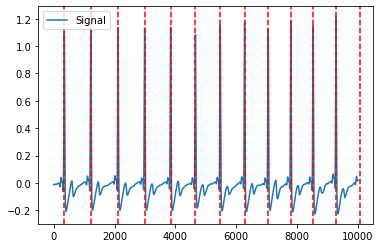

In [4]:
# Plot ecg with R peaks (only a subset, otherwise the plot becomes unreadable!)
ecg_processed, ecg_info = nk.ecg_process(signals['ECG'], sampling_rate=fs)
rpeaks = ecg_info["ECG_R_Peaks"]
cleaned_ecg = ecg_processed["ECG_Clean"]
plot = nk.events_plot(rpeaks[0:13], cleaned_ecg[0:10000])

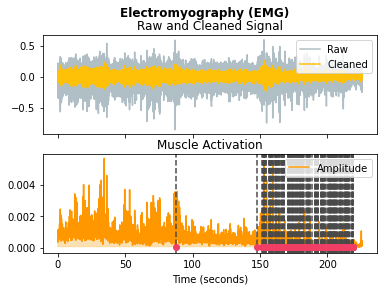

In [5]:
# Plot filtered emg
emg_processed, _ = nk.emg_process(signals['EMG'], sampling_rate=fs)
plot = nk.emg_plot(emg_processed, fs)

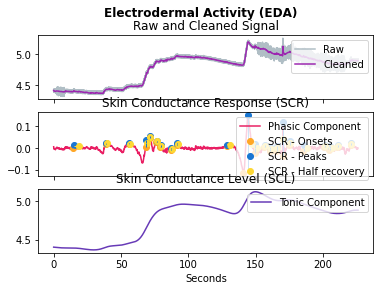

In [19]:
# Plot filtered eda
eda_processed, features = nk.eda_process(signals['EDA'], sampling_rate=fs, method="neurokit")
plot = nk.eda_plot(eda_processed, fs)

In [4]:
# Extraction of features

fs = 1000
window = 30
experiment_type = 'stroophard'
load_path = os.path.join(os.getcwd(), 'experiments', experiment_type)

In [21]:
# ECG 
# do not run it since there is the csv loaded after
#dataframe_ECG = sis.extract_plux_data_windowed(load_path, 0, window, 'ECG')
# np.save("dataframe_ECG.npy", dataframe_ECG)

In [22]:
# dataframe_ECG = np.load("dataframe_ECG.npy")
# cg_time_and_freq_features = sis.extract_time_and_freq_hrv_features(dataframe_ECG, fs)

In [5]:
# EDA
# have to fix this and make it a pd.DataFrame()
dataframe_EDA = sis.extract_plux_data_windowed(load_path, 0, window, 'EDA')
# np.save("dataframe_EDA.npy", dataframe_EDA)

100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


In [6]:
# dataframe_EDA = np.load("dataframe_EDA.npy")
eda_time_and_freq_features = sis.extract_eda_time_and_frequency_features(dataframe_EDA, fs, window)

C:\robotics-conda\sensors_import_support.py:254: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[f'skewMFCCS_{k}'] = None
C:\robotics-conda\sensors_import_support.py:254: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[f'skewMFCCS_{k}'] = None
C:\robotics-conda\sensors_import_support.py:254: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To g

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7966e+04 -4.7941e+04  3e+04  2e+02  1e+02
 1: -4.7942e+04 -4.8540e+04  6e+02  3e+00  2e+00
 2: -4.7949e+04 -4.8071e+04  1e+02  6e-01  4e-01
 3: -4.7949e+04 -4.8004e+04  5e+01  1e-01  9e-02
 4: -4.7955e+04 -4.7980e+04  3e+01  2e-02  2e-02
 5: -4.7967e+04 -4.7975e+04  8e+00  7e-03  5e-03
 6: -4.7968e+04 -4.7975e+04  7e+00  5e-03  3e-03
 7: -4.7971e+04 -4.7974e+04  3e+00  2e-03  1e-03
 8: -4.7971e+04 -4.7974e+04  3e+00  2e-03  1e-03
 9: -4.7973e+04 -4.7974e+04  1e+00  3e-04  2e-04
10: -4.7973e+04 -4.7974e+04  1e+00  3e-04  2e-04
11: -4.7973e+04 -4.7974e+04  4e-01  7e-05  5e-05
12: -4.7973e+04 -4.7974e+04  4e-01  6e-05  4e-05
13: -4.7974e+04 -4.7974e+04  1e-01  6e-06  4e-06
14: -4.7974e+04 -4.7974e+04  1e-01  4e-06  3e-06
15: -4.7974e+04 -4.7974e+04  3e-02  5e-07

  1%|          | 1/109 [00:02<04:56,  2.74s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7723e+04 -2.7232e+04  5e+04  2e+02  4e+02
 1: -2.8088e+04 -3.4026e+04  7e+03  3e+01  6e+01
 2: -2.8291e+04 -2.9240e+04  1e+03  3e+00  6e+00
 3: -2.8304e+04 -2.8439e+04  1e+02  4e-01  7e-01
 4: -2.8312e+04 -2.8376e+04  6e+01  1e-01  2e-01
 5: -2.8328e+04 -2.8348e+04  2e+01  2e-02  3e-02
 6: -2.8332e+04 -2.8346e+04  1e+01  7e-03  1e-02
 7: -2.8339e+04 -2.8344e+04  5e+00  2e-03  4e-03
 8: -2.8339e+04 -2.8344e+04  4e+00  1e-03  3e-03
 9: -2.8342e+04 -2.8343e+04  2e+00  4e-04  8e-04
10: -2.8342e+04 -2.8343e+04  2e+00  4e-04  7e-04
11: -2.8342e+04 -2.8343e+04  7e-01  9e-05  2e-04
12: -2.8343e+04 -2.8343e+04  6e-01  7e-05  1e-04
13: -2.8343e+04 -2.8343e+04  2e-01  1e-05  2e-05
14: -2.8343e+04 -2.8343e+04  2e-01  8e-06  1e-05
15: -2.8343e+04 -2.8343e+04  6e-02  2e-06

  2%|▏         | 2/109 [00:05<04:23,  2.46s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.1167e+03 -9.0920e+03  3e+04  2e+02  3e+02
 1: -9.1048e+03 -1.0061e+04  1e+03  5e+00  9e+00
 2: -9.1138e+03 -9.2061e+03  9e+01  4e-01  7e-01
 3: -9.1208e+03 -9.1396e+03  2e+01  6e-03  1e-02
 4: -9.1296e+03 -9.1381e+03  8e+00  1e-03  2e-03
 5: -9.1342e+03 -9.1372e+03  3e+00  3e-04  5e-04
 6: -9.1343e+03 -9.1372e+03  3e+00  3e-04  5e-04
 7: -9.1357e+03 -9.1369e+03  1e+00  7e-05  1e-04
 8: -9.1357e+03 -9.1369e+03  1e+00  6e-05  9e-05
 9: -9.1364e+03 -9.1368e+03  4e-01  1e-05  2e-05
10: -9.1364e+03 -9.1368e+03  4e-01  1e-05  2e-05
11: -9.1366e+03 -9.1368e+03  2e-01  3e-06  4e-06
12: -9.1367e+03 -9.1368e+03  2e-01  2e-06  4e-06
13: -9.1367e+03 -9.1368e+03  6e-02  4e-07  7e-07
14: -9.1368e+03 -9.1368e+03  2e-02  6e-08  1e-07
15: -9.1368e+03 -9.1368e+03  2e-02  3e-08

  3%|▎         | 3/109 [00:07<04:09,  2.35s/it]

17: -9.1368e+03 -9.1368e+03  7e-03  1e-08  1e-07
18: -9.1368e+03 -9.1368e+03  1e-03  8e-09  2e-07
19: -9.1368e+03 -9.1368e+03  4e-04  8e-09  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8244e+01 -1.3567e+01  3e+04  2e+02  1e+03
 1: -1.4219e+01 -5.3104e+02  5e+02  3e+00  2e+01
 2: -1.8560e+01 -6.8246e+01  5e+01  2e-01  1e+00
 3: -2.9530e+01 -4.1197e+01  1e+01  4e-03  3e-02
 4: -3.6721e+01 -4.0470e+01  4e+00  5e-04  3e-03
 5: -3.9048e+01 -4.0165e+01  1e+00  1e-04  1e-03
 6: -3.9137e+01 -4.0149e+01  1e+00  1e-04  8e-04
 7: -3.9637e+01 -4.0063e+01  4e-01  3e-05  2e-04
 8: -3.9666e+01 -4.0064e+01  4e-01  3e-05  2e-04
 9: -3.9927e+01 -4.0043e+01  1e-01  3e-06  2e-05
10: -3.9932e+01 -4.0043e+01  1e-01  2e-06  2e-05
11: -4.0006e+01 -4.0038e+01  3e-02  2e-07  2e-06
12: -4.

  4%|▎         | 4/109 [00:09<04:15,  2.43s/it]

15: -4.0036e+01 -4.0037e+01  5e-04  4e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.6381e+02 -7.3856e+02  3e+04  2e+02  8e+02
 1: -7.4045e+02 -1.3100e+03  6e+02  3e+00  1e+01
 2: -7.4710e+02 -8.1369e+02  7e+01  3e-01  1e+00
 3: -7.5287e+02 -7.7661e+02  2e+01  4e-02  2e-01
 4: -7.6188e+02 -7.7013e+02  8e+00  4e-04  2e-03
 5: -7.6621e+02 -7.6923e+02  3e+00  5e-06  2e-05
 6: -7.6655e+02 -7.6920e+02  3e+00  4e-06  2e-05
 7: -7.6795e+02 -7.6899e+02  1e+00  1e-06  5e-06
 8: -7.6803e+02 -7.6899e+02  1e+00  9e-07  4e-06
 9: -7.6864e+02 -7.6893e+02  3e-01  1e-07  6e-07
10: -7.6866e+02 -7.6893e+02  3e-01  1e-07  5e-07
11: -7.6885e+02 -7.6892e+02  7e-02  2e-08  2e-07
12: -7.6885e+02 -7.6892e+02  7e-02  2e-08  2e-07
13: -7.6889e+02 -7.6892e+02  3e-02  1e-08  2e-07
14: -7.

  5%|▍         | 5/109 [00:12<04:24,  2.54s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.1896e+02 -7.9422e+02  3e+04  2e+02  8e+02
 1: -7.9571e+02 -1.3776e+03  6e+02  3e+00  2e+01
 2: -8.0169e+02 -8.7365e+02  7e+01  3e-01  1e+00
 3: -8.0726e+02 -8.3401e+02  3e+01  6e-02  3e-01
 4: -8.1124e+02 -8.2755e+02  2e+01  2e-02  9e-02
 5: -8.2134e+02 -8.2437e+02  3e+00  4e-03  2e-02
 6: -8.2148e+02 -8.2430e+02  3e+00  3e-03  1e-02
 7: -8.2287e+02 -8.2394e+02  1e+00  7e-04  3e-03
 8: -8.2292e+02 -8.2393e+02  1e+00  6e-04  3e-03
 9: -8.2344e+02 -8.2387e+02  4e-01  2e-04  8e-04
10: -8.2345e+02 -8.2387e+02  4e-01  2e-04  7e-04
11: -8.2369e+02 -8.2385e+02  2e-01  2e-05  1e-04
12: -8.2378e+02 -8.2384e+02  6e-02  6e-06  3e-05
13: -8.2379e+02 -8.2384e+02  5e-02  5e-06  2e-05
14: -8.2382e+02 -8.2384e+02  2e-02  6e-07  3e-06
15: -8.

  6%|▌         | 6/109 [00:16<05:13,  3.05s/it]

18: -8.2384e+02 -8.2384e+02  2e-05  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6115e+03 -1.5825e+03  3e+04  2e+02  6e+02
 1: -1.5873e+03 -2.2216e+03  6e+02  4e+00  1e+01
 2: -1.5945e+03 -1.6814e+03  9e+01  4e-01  1e+00
 3: -1.5998e+03 -1.6263e+03  3e+01  5e-02  2e-01
 4: -1.6088e+03 -1.6186e+03  1e+01  5e-04  2e-03
 5: -1.6139e+03 -1.6179e+03  4e+00  2e-04  7e-04
 6: -1.6141e+03 -1.6179e+03  4e+00  2e-04  6e-04
 7: -1.6160e+03 -1.6176e+03  2e+00  5e-05  2e-04
 8: -1.6160e+03 -1.6176e+03  2e+00  4e-05  2e-04
 9: -1.6169e+03 -1.6175e+03  6e-01  9e-06  3e-05
10: -1.6170e+03 -1.6175e+03  6e-01  7e-06  3e-05
11: -1.6173e+03 -1.6175e+03  2e-01  2e-06  6e-06
12: -1.6173e+03 -1.6175e+03  2e-01  1e-06  5e-06
13: -1.6174e+03 -1.6175e+03  8e-02  3e-07  9e-07
14: -1.

  6%|▋         | 7/109 [00:20<05:45,  3.38s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4376e+04 -5.4258e+04  4e+04  2e+02  1e+02
 1: -5.4404e+04 -5.6368e+04  2e+03  1e+01  7e+00
 2: -5.4420e+04 -5.4556e+04  1e+02  6e-01  4e-01
 3: -5.4426e+04 -5.4464e+04  4e+01  9e-02  6e-02
 4: -5.4438e+04 -5.4449e+04  1e+01  9e-04  6e-04
 5: -5.4443e+04 -5.4448e+04  4e+00  1e-04  7e-05
 6: -5.4443e+04 -5.4447e+04  4e+00  8e-05  6e-05
 7: -5.4446e+04 -5.4447e+04  2e+00  2e-05  2e-05
 8: -5.4446e+04 -5.4447e+04  1e+00  2e-05  1e-05
 9: -5.4446e+04 -5.4447e+04  5e-01  4e-06  3e-06
10: -5.4447e+04 -5.4447e+04  5e-01  3e-06  2e-06
11: -5.4447e+04 -5.4447e+04  2e-01  7e-07  4e-07
12: -5.4447e+04 -5.4447e+04  2e-01  5e-07  3e-07
13: -5.4447e+04 -5.4447e+04  6e-02  1e-07  1e-07
14: -5.4447e+04 -5.4447e+04  6e-02  1e-07  8e-08
15: -5.

  7%|▋         | 8/109 [00:24<05:55,  3.52s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1147e+03 -3.0605e+03  3e+04  2e+02  8e+02
 1: -3.1322e+03 -4.7310e+03  2e+03  9e+00  4e+01
 2: -3.1511e+03 -3.3222e+03  2e+02  8e-01  4e+00
 3: -3.1585e+03 -3.1924e+03  3e+01  1e-01  5e-01
 4: -3.1648e+03 -3.1792e+03  1e+01  1e-03  5e-03
 5: -3.1736e+03 -3.1774e+03  4e+00  2e-04  1e-03
 6: -3.1738e+03 -3.1773e+03  3e+00  2e-04  8e-04
 7: -3.1755e+03 -3.1769e+03  1e+00  5e-05  2e-04
 8: -3.1756e+03 -3.1769e+03  1e+00  5e-05  2e-04
 9: -3.1762e+03 -3.1768e+03  6e-01  1e-05  5e-05
10: -3.1763e+03 -3.1768e+03  5e-01  7e-06  3e-05
11: -3.1766e+03 -3.1768e+03  2e-01  2e-06  1e-05
12: -3.1766e+03 -3.1768e+03  1e-01  8e-07  4e-06
13: -3.1767e+03 -3.1768e+03  5e-02  2e-07  1e-06
14: -3.1767e+03 -3.1768e+03  4e-02  2e-07  9e-07
15: -3.

  8%|▊         | 9/109 [00:29<06:26,  3.86s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.6562e+03 -8.6213e+03  3e+04  2e+02  3e+02
 1: -8.6354e+03 -9.5159e+03  9e+02  5e+00  8e+00
 2: -8.6452e+03 -8.7493e+03  1e+02  5e-01  8e-01
 3: -8.6531e+03 -8.6784e+03  3e+01  6e-02  9e-02
 4: -8.6591e+03 -8.6719e+03  1e+01  1e-02  2e-02
 5: -8.6666e+03 -8.6701e+03  3e+00  3e-03  5e-03
 6: -8.6669e+03 -8.6700e+03  3e+00  2e-03  3e-03
 7: -8.6683e+03 -8.6696e+03  1e+00  7e-04  1e-03
 8: -8.6684e+03 -8.6696e+03  1e+00  6e-04  1e-03
 9: -8.6691e+03 -8.6695e+03  4e-01  1e-04  2e-04
10: -8.6691e+03 -8.6695e+03  4e-01  1e-04  2e-04
11: -8.6693e+03 -8.6695e+03  2e-01  2e-05  3e-05
12: -8.6694e+03 -8.6695e+03  6e-02  3e-06  6e-06
13: -8.6694e+03 -8.6695e+03  6e-02  3e-06  5e-06
14: -8.6695e+03 -8.6695e+03  2e-02  5e-07  9e-07
15: -8.6695e+03 -8.6695e+03  1e-02  1e-07

  9%|▉         | 10/109 [00:32<06:04,  3.68s/it]

16: -8.6695e+03 -8.6695e+03  4e-03  2e-08  7e-08
17: -8.6695e+03 -8.6695e+03  2e-03  1e-08  4e-08
18: -8.6695e+03 -8.6695e+03  1e-04  1e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5246e+03 -4.4963e+03  3e+04  2e+02  4e+02
 1: -4.5024e+03 -5.2709e+03  8e+02  4e+00  1e+01
 2: -4.5108e+03 -4.5875e+03  8e+01  3e-01  8e-01
 3: -4.5178e+03 -4.5426e+03  2e+01  5e-02  1e-01
 4: -4.5251e+03 -4.5352e+03  1e+01  3e-03  6e-03
 5: -4.5308e+03 -4.5341e+03  3e+00  8e-04  2e-03
 6: -4.5310e+03 -4.5341e+03  3e+00  6e-04  2e-03
 7: -4.5325e+03 -4.5338e+03  1e+00  2e-04  5e-04
 8: -4.5326e+03 -4.5338e+03  1e+00  2e-04  4e-04
 9: -4.5333e+03 -4.5338e+03  5e-01  3e-05  8e-05
10: -4.5333e+03 -4.5338e+03  4e-01  3e-05  7e-05
11: -4.5335e+03 -4.5337e+03  2e-01  7e-06  2e-05
12: -4.

 10%|█         | 11/109 [00:34<05:30,  3.37s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8605e+03 -1.7526e+03  4e+04  2e+02  9e+02
 1: -1.9001e+03 -4.5918e+03  3e+03  1e+01  7e+01
 2: -1.9361e+03 -2.1358e+03  2e+02  9e-01  4e+00
 3: -1.9449e+03 -1.9910e+03  5e+01  1e-01  7e-01
 4: -1.9499e+03 -1.9723e+03  2e+01  3e-02  1e-01
 5: -1.9564e+03 -1.9678e+03  1e+01  5e-03  2e-02
 6: -1.9620e+03 -1.9664e+03  4e+00  1e-03  6e-03
 7: -1.9622e+03 -1.9664e+03  4e+00  1e-03  5e-03
 8: -1.9644e+03 -1.9660e+03  2e+00  2e-04  1e-03
 9: -1.9650e+03 -1.9659e+03  9e-01  6e-05  3e-04
10: -1.9655e+03 -1.9658e+03  3e-01  2e-05  7e-05
11: -1.9655e+03 -1.9658e+03  3e-01  1e-05  7e-05
12: -1.9657e+03 -1.9658e+03  1e-01  3e-06  1e-05
13: -1.9658e+03 -1.9658e+03  5e-02  5e-07  2e-06
14: -1.9658e+03 -1.9658e+03  2e-02  8e-08  4e-07
15: -1.9658e+03 -1.9658e+03  8e-03  2e-08

 11%|█         | 12/109 [00:38<05:41,  3.52s/it]

16: -1.9658e+03 -1.9658e+03  1e-03  2e-08  3e-07
17: -1.9658e+03 -1.9658e+03  2e-04  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1758e+03 -1.0998e+03  4e+04  2e+02  1e+03
 1: -1.2040e+03 -3.7406e+03  3e+03  1e+01  1e+02
 2: -1.2740e+03 -1.6872e+03  4e+02  2e+00  1e+01
 3: -1.2771e+03 -1.3701e+03  9e+01  2e-01  2e+00
 4: -1.2914e+03 -1.3143e+03  2e+01  3e-02  2e-01
 5: -1.2966e+03 -1.3104e+03  1e+01  1e-02  8e-02
 6: -1.3037e+03 -1.3083e+03  5e+00  3e-03  2e-02
 7: -1.3041e+03 -1.3082e+03  4e+00  2e-03  2e-02
 8: -1.3062e+03 -1.3077e+03  2e+00  7e-04  5e-03
 9: -1.3063e+03 -1.3077e+03  1e+00  5e-04  4e-03
10: -1.3071e+03 -1.3076e+03  5e-01  1e-04  9e-04
11: -1.3071e+03 -1.3076e+03  5e-01  1e-04  8e-04
12: -1.3074e+03 -1.3076e+03  2e-01  3e-05  2e-04
13: -1.

 12%|█▏        | 13/109 [00:41<05:16,  3.29s/it]

19: -1.3076e+03 -1.3076e+03  2e-04  1e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.2313e+03 -6.1597e+03  3e+04  2e+02  4e+02
 1: -6.2422e+03 -7.7880e+03  2e+03  9e+00  2e+01
 2: -6.2576e+03 -6.3519e+03  9e+01  4e-01  9e-01
 3: -6.2677e+03 -6.2837e+03  2e+01  4e-03  9e-03
 4: -6.2771e+03 -6.2829e+03  6e+00  4e-05  9e-05
 5: -6.2801e+03 -6.2824e+03  2e+00  1e-05  3e-05
 6: -6.2802e+03 -6.2824e+03  2e+00  1e-05  3e-05
 7: -6.2811e+03 -6.2822e+03  1e+00  4e-06  9e-06
 8: -6.2812e+03 -6.2822e+03  1e+00  3e-06  7e-06
 9: -6.2817e+03 -6.2821e+03  4e-01  7e-07  2e-06
10: -6.2817e+03 -6.2821e+03  3e-01  5e-07  1e-06
11: -6.2820e+03 -6.2820e+03  9e-02  9e-08  2e-07
12: -6.2820e+03 -6.2820e+03  8e-02  7e-08  2e-07
13: -6.2820e+03 -6.2820e+03  3e-02  1e-08  7e-08
14: -6.

 13%|█▎        | 14/109 [00:45<05:22,  3.39s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0290e+04 -2.0238e+04  3e+04  2e+02  2e+02
 1: -2.0298e+04 -2.1684e+04  1e+03  8e+00  9e+00
 2: -2.0317e+04 -2.0415e+04  1e+02  4e-01  5e-01
 3: -2.0327e+04 -2.0343e+04  2e+01  2e-02  2e-02
 4: -2.0334e+04 -2.0341e+04  7e+00  2e-03  2e-03
 5: -2.0338e+04 -2.0341e+04  2e+00  4e-04  5e-04
 6: -2.0339e+04 -2.0341e+04  2e+00  2e-04  3e-04
 7: -2.0340e+04 -2.0340e+04  8e-01  9e-05  1e-04
 8: -2.0340e+04 -2.0340e+04  7e-01  7e-05  7e-05
 9: -2.0340e+04 -2.0340e+04  3e-01  2e-05  2e-05
10: -2.0340e+04 -2.0340e+04  2e-01  1e-05  2e-05
11: -2.0340e+04 -2.0340e+04  8e-02  2e-06  3e-06
12: -2.0340e+04 -2.0340e+04  7e-02  2e-06  2e-06
13: -2.0340e+04 -2.0340e+04  2e-02  3e-07  4e-07
14: -2.0340e+04 -2.0340e+04  2e-02  2e-07  2e-07
15: -2.0340e+04 -2.0340e+04  3e-03  2e-08

 14%|█▍        | 15/109 [00:47<04:58,  3.18s/it]

16: -2.0340e+04 -2.0340e+04  1e-03  1e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0627e+04 -2.0581e+04  3e+04  2e+02  2e+02
 1: -2.0618e+04 -2.1802e+04  1e+03  7e+00  7e+00
 2: -2.0622e+04 -2.0666e+04  4e+01  1e-01  1e-01
 3: -2.0641e+04 -2.0647e+04  6e+00  1e-03  1e-03
 4: -2.0644e+04 -2.0646e+04  2e+00  2e-04  3e-04
 5: -2.0645e+04 -2.0646e+04  1e+00  8e-05  9e-05
 6: -2.0645e+04 -2.0646e+04  9e-01  7e-05  7e-05
 7: -2.0645e+04 -2.0646e+04  4e-01  2e-05  3e-05
 8: -2.0646e+04 -2.0646e+04  4e-01  2e-05  2e-05
 9: -2.0646e+04 -2.0646e+04  1e-01  4e-06  4e-06
10: -2.0646e+04 -2.0646e+04  1e-01  3e-06  3e-06
11: -2.0646e+04 -2.0646e+04  4e-02  8e-07  8e-07
12: -2.0646e+04 -2.0646e+04  4e-02  6e-07  7e-07
13: -2.0646e+04 -2.0646e+04  1e-02  1e-07  1e-07
14: -2.

 15%|█▍        | 16/109 [00:50<04:42,  3.03s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.2435e+03 -9.2180e+03  3e+04  2e+02  3e+02
 1: -9.2193e+03 -9.7667e+03  6e+02  3e+00  5e+00
 2: -9.2229e+03 -9.2720e+03  5e+01  2e-01  3e-01
 3: -9.2358e+03 -9.2454e+03  1e+01  2e-03  3e-03
 4: -9.2433e+03 -9.2450e+03  2e+00  3e-04  4e-04
 5: -9.2441e+03 -9.2449e+03  8e-01  5e-05  8e-05
 6: -9.2442e+03 -9.2449e+03  7e-01  4e-05  6e-05
 7: -9.2446e+03 -9.2448e+03  2e-01  1e-05  2e-05
 8: -9.2446e+03 -9.2448e+03  2e-01  8e-06  1e-05
 9: -9.2447e+03 -9.2448e+03  9e-02  2e-06  4e-06
10: -9.2447e+03 -9.2448e+03  8e-02  2e-06  3e-06
11: -9.2448e+03 -9.2448e+03  2e-02  2e-07  4e-07
12: -9.2448e+03 -9.2448e+03  2e-02  2e-07  3e-07
13: -9.2448e+03 -9.2448e+03  4e-03  2e-08  5e-08
14: -9.2448e+03 -9.2448e+03  1e-03  3e-09  4e-08
15: -9.

 16%|█▌        | 17/109 [00:52<04:18,  2.81s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6083e+03 -2.5824e+03  3e+04  2e+02  6e+02
 1: -2.5839e+03 -3.1896e+03  6e+02  3e+00  1e+01
 2: -2.5877e+03 -2.6444e+03  6e+01  2e-01  8e-01
 3: -2.6018e+03 -2.6106e+03  9e+00  2e-03  8e-03
 4: -2.6092e+03 -2.6103e+03  1e+00  2e-04  9e-04
 5: -2.6097e+03 -2.6102e+03  5e-01  5e-05  2e-04
 6: -2.6097e+03 -2.6102e+03  5e-01  4e-05  2e-04
 7: -2.6100e+03 -2.6102e+03  2e-01  1e-05  4e-05
 8: -2.6100e+03 -2.6102e+03  2e-01  7e-06  3e-05
 9: -2.6101e+03 -2.6102e+03  7e-02  3e-06  9e-06
10: -2.6101e+03 -2.6102e+03  6e-02  2e-06  8e-06
11: -2.6101e+03 -2.6102e+03  2e-02  4e-07  1e-06
12: -2.6101e+03 -2.6102e+03  2e-02  3e-07  1e-06
13: -2.6101e+03 -2.6102e+03  6e-03  6e-08  2e-07
14: -2.6102e+03 -2.6102e+03  3e-03  1e-08  8e-08
15: -2.

 17%|█▋        | 18/109 [00:56<04:24,  2.91s/it]

16: -2.6102e+03 -2.6102e+03  3e-04  1e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8906e+03 -8.8614e+03  3e+04  2e+02  3e+02
 1: -8.8715e+03 -9.7260e+03  9e+02  5e+00  8e+00
 2: -8.8752e+03 -8.9424e+03  7e+01  3e-01  4e-01
 3: -8.8864e+03 -8.8991e+03  1e+01  3e-03  4e-03
 4: -8.8964e+03 -8.8986e+03  2e+00  5e-04  8e-04
 5: -8.8964e+03 -8.8986e+03  2e+00  4e-04  6e-04
 6: -8.8976e+03 -8.8985e+03  8e-01  1e-04  2e-04
 7: -8.8977e+03 -8.8985e+03  7e-01  7e-05  1e-04
 8: -8.8981e+03 -8.8984e+03  3e-01  2e-05  3e-05
 9: -8.8982e+03 -8.8984e+03  2e-01  1e-05  2e-05
10: -8.8983e+03 -8.8984e+03  9e-02  4e-06  7e-06
11: -8.8983e+03 -8.8984e+03  8e-02  3e-06  6e-06
12: -8.8983e+03 -8.8984e+03  3e-02  8e-07  1e-06
13: -8.8983e+03 -8.8984e+03  3e-02  5e-07  9e-07
14: -8.

 17%|█▋        | 19/109 [00:59<04:31,  3.02s/it]

18: -8.8984e+03 -8.8984e+03  2e-04  3e-09  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0903e+04 -3.0704e+04  4e+04  2e+02  2e+02
 1: -3.0995e+04 -3.3678e+04  3e+03  1e+01  1e+01
 2: -3.1044e+04 -3.1346e+04  3e+02  1e+00  1e+00
 3: -3.1054e+04 -3.1170e+04  1e+02  4e-01  4e-01
 4: -3.1059e+04 -3.1097e+04  4e+01  5e-02  4e-02
 5: -3.1070e+04 -3.1085e+04  2e+01  2e-02  1e-02
 6: -3.1075e+04 -3.1082e+04  7e+00  7e-03  6e-03
 7: -3.1078e+04 -3.1081e+04  3e+00  2e-03  2e-03
 8: -3.1079e+04 -3.1080e+04  1e+00  6e-04  5e-04
 9: -3.1080e+04 -3.1080e+04  4e-01  6e-05  5e-05
10: -3.1080e+04 -3.1080e+04  4e-01  5e-05  4e-05
11: -3.1080e+04 -3.1080e+04  1e-01  8e-06  7e-06
12: -3.1080e+04 -3.1080e+04  7e-02  3e-06  2e-06
13: -3.1080e+04 -3.1080e+04  2e-02  6e-07  6e-07
14: -3.

 18%|█▊        | 20/109 [01:02<04:22,  2.95s/it]

15: -3.1080e+04 -3.1080e+04  7e-03  1e-07  1e-07
16: -3.1080e+04 -3.1080e+04  2e-03  3e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9860e+04 -1.9826e+04  3e+04  2e+02  2e+02
 1: -1.9841e+04 -2.0716e+04  9e+02  5e+00  5e+00
 2: -1.9850e+04 -1.9953e+04  1e+02  5e-01  5e-01
 3: -1.9856e+04 -1.9912e+04  6e+01  2e-01  2e-01
 4: -1.9859e+04 -1.9908e+04  5e+01  1e-01  1e-01
 5: -1.9868e+04 -1.9892e+04  2e+01  6e-02  6e-02
 6: -1.9869e+04 -1.9892e+04  2e+01  5e-02  5e-02
 7: -1.9877e+04 -1.9887e+04  1e+01  2e-02  2e-02
 8: -1.9878e+04 -1.9887e+04  9e+00  1e-02  1e-02
 9: -1.9881e+04 -1.9886e+04  4e+00  5e-03  5e-03
10: -1.9882e+04 -1.9886e+04  4e+00  4e-03  4e-03
11: -1.9884e+04 -1.9885e+04  1e+00  9e-04  1e-03
12: -1.9884e+04 -1.9885e+04  1e+00  7e-04  7e-04
13: -1.

 19%|█▉        | 21/109 [01:05<04:34,  3.12s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0683e+04 -1.0656e+04  3e+04  2e+02  3e+02
 1: -1.0660e+04 -1.1323e+04  7e+02  4e+00  5e+00
 2: -1.0671e+04 -1.0791e+04  1e+02  6e-01  9e-01
 3: -1.0677e+04 -1.0741e+04  6e+01  2e-01  3e-01
 4: -1.0682e+04 -1.0722e+04  4e+01  8e-02  1e-01
 5: -1.0687e+04 -1.0714e+04  3e+01  4e-02  5e-02
 6: -1.0688e+04 -1.0713e+04  3e+01  3e-02  4e-02
 7: -1.0697e+04 -1.0708e+04  1e+01  1e-02  2e-02
 8: -1.0698e+04 -1.0708e+04  1e+01  8e-03  1e-02
 9: -1.0703e+04 -1.0707e+04  4e+00  3e-03  4e-03
10: -1.0703e+04 -1.0706e+04  4e+00  2e-03  3e-03
11: -1.0705e+04 -1.0706e+04  1e+00  5e-04  7e-04
12: -1.0705e+04 -1.0706e+04  1e+00  4e-04  6e-04
13: -1.0706e+04 -1.0706e+04  4e-01  1e-04  1e-04
14: -1.0706e+04 -1.0706e+04  4e-01  8e-05  1e-04
15: -1.

 20%|██        | 22/109 [01:10<05:04,  3.50s/it]

18: -1.0706e+04 -1.0706e+04  3e-04  8e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.3475e+03 -4.3218e+03  3e+04  2e+02  4e+02
 1: -4.3270e+03 -5.1773e+03  9e+02  5e+00  1e+01
 2: -4.3455e+03 -4.5245e+03  2e+02  9e-01  2e+00
 3: -4.3574e+03 -4.4563e+03  1e+02  3e-01  7e-01
 4: -4.3605e+03 -4.4530e+03  9e+01  3e-01  6e-01
 5: -4.3736e+03 -4.4188e+03  5e+01  1e-01  3e-01
 6: -4.3758e+03 -4.4192e+03  4e+01  1e-01  2e-01
 7: -4.3850e+03 -4.4124e+03  3e+01  5e-02  1e-01
 8: -4.3861e+03 -4.4130e+03  3e+01  5e-02  1e-01
 9: -4.3947e+03 -4.4096e+03  1e+01  2e-02  4e-02
10: -4.3950e+03 -4.4094e+03  1e+01  2e-02  3e-02
11: -4.4010e+03 -4.4068e+03  6e+00  3e-03  7e-03
12: -4.4021e+03 -4.4066e+03  4e+00  2e-03  4e-03
13: -4.4045e+03 -4.4062e+03  2e+00  6e-04  1e-03
14: -4.

 21%|██        | 23/109 [01:14<05:15,  3.67s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8137e+02 -3.5654e+02  3e+04  2e+02  1e+03
 1: -3.5694e+02 -9.0705e+02  6e+02  3e+00  2e+01
 2: -3.6544e+02 -4.7850e+02  1e+02  6e-01  3e+00
 3: -3.6956e+02 -4.3810e+02  7e+01  2e-01  1e+00
 4: -3.7184e+02 -4.2796e+02  6e+01  2e-01  9e-01
 5: -3.8139e+02 -4.0866e+02  3e+01  7e-02  4e-01
 6: -3.8317e+02 -4.0915e+02  3e+01  6e-02  3e-01
 7: -3.9093e+02 -4.0564e+02  1e+01  3e-02  2e-01
 8: -3.9173e+02 -4.0550e+02  1e+01  2e-02  1e-01
 9: -3.9825e+02 -4.0321e+02  5e+00  5e-03  3e-02
10: -3.9874e+02 -4.0307e+02  4e+00  3e-03  2e-02
11: -4.0130e+02 -4.0271e+02  1e+00  7e-04  4e-03
12: -4.0147e+02 -4.0269e+02  1e+00  5e-04  3e-03
13: -4.0221e+02 -4.0265e+02  4e-01  1e-04  8e-04
14: -4.0249e+02 -4.0264e+02  2e-01  1e-05  7e-05
15: -4.

 22%|██▏       | 24/109 [01:18<05:24,  3.81s/it]

16: -4.0263e+02 -4.0264e+02  9e-03  2e-07  9e-07
17: -4.0264e+02 -4.0264e+02  3e-04  9e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5678e+03 -1.5432e+03  3e+04  2e+02  6e+02
 1: -1.5433e+03 -2.0480e+03  5e+02  3e+00  1e+01
 2: -1.5489e+03 -1.6290e+03  8e+01  4e-01  1e+00
 3: -1.5532e+03 -1.5993e+03  5e+01  1e-01  5e-01
 4: -1.5539e+03 -1.5984e+03  4e+01  1e-01  5e-01
 5: -1.5621e+03 -1.5848e+03  2e+01  6e-02  2e-01
 6: -1.5640e+03 -1.5853e+03  2e+01  5e-02  2e-01
 7: -1.5708e+03 -1.5826e+03  1e+01  2e-02  7e-02
 8: -1.5714e+03 -1.5824e+03  1e+01  2e-02  6e-02
 9: -1.5776e+03 -1.5806e+03  3e+00  2e-03  7e-03
10: -1.5786e+03 -1.5805e+03  2e+00  8e-04  3e-03
11: -1.5798e+03 -1.5804e+03  6e-01  2e-04  8e-04
12: -1.5798e+03 -1.5804e+03  6e-01  2e-04  5e-04
13: -1.

 23%|██▎       | 25/109 [01:21<04:59,  3.56s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.2402e+03 -7.2144e+03  3e+04  2e+02  3e+02
 1: -7.2151e+03 -7.7728e+03  6e+02  3e+00  5e+00
 2: -7.2206e+03 -7.2863e+03  7e+01  3e-01  5e-01
 3: -7.2257e+03 -7.2614e+03  4e+01  1e-01  2e-01
 4: -7.2275e+03 -7.2582e+03  3e+01  7e-02  1e-01
 5: -7.2360e+03 -7.2500e+03  1e+01  3e-02  5e-02
 6: -7.2369e+03 -7.2500e+03  1e+01  2e-02  4e-02
 7: -7.2422e+03 -7.2485e+03  6e+00  9e-03  2e-02
 8: -7.2425e+03 -7.2485e+03  6e+00  7e-03  1e-02
 9: -7.2463e+03 -7.2479e+03  2e+00  9e-04  2e-03
10: -7.2467e+03 -7.2479e+03  1e+00  5e-04  8e-04
11: -7.2475e+03 -7.2478e+03  3e-01  9e-05  1e-04
12: -7.2476e+03 -7.2478e+03  2e-01  5e-05  8e-05
13: -7.2478e+03 -7.2478e+03  5e-02  9e-06  2e-05
14: -7.2478e+03 -7.2478e+03  5e-03  3e-07  6e-07


 24%|██▍       | 26/109 [01:24<04:38,  3.36s/it]

15: -7.2478e+03 -7.2478e+03  1e-04  5e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1424e+04 -1.1376e+04  3e+04  2e+02  3e+02
 1: -1.1415e+04 -1.2352e+04  1e+03  5e+00  7e+00
 2: -1.1424e+04 -1.1545e+04  1e+02  6e-01  8e-01
 3: -1.1429e+04 -1.1487e+04  6e+01  2e-01  2e-01
 4: -1.1434e+04 -1.1475e+04  4e+01  9e-02  1e-01
 5: -1.1436e+04 -1.1475e+04  4e+01  7e-02  1e-01
 6: -1.1449e+04 -1.1467e+04  2e+01  2e-02  3e-02
 7: -1.1451e+04 -1.1466e+04  2e+01  1e-02  2e-02
 8: -1.1458e+04 -1.1464e+04  6e+00  5e-03  7e-03
 9: -1.1459e+04 -1.1464e+04  6e+00  4e-03  6e-03
10: -1.1462e+04 -1.1464e+04  2e+00  6e-04  8e-04
11: -1.1463e+04 -1.1464e+04  1e+00  4e-04  5e-04
12: -1.1463e+04 -1.1464e+04  3e-01  7e-05  1e-04
13: -1.1464e+04 -1.1464e+04  2e-01  3e-05  4e-05
14: -1.

 25%|██▍       | 27/109 [01:26<04:18,  3.16s/it]

16: -1.1464e+04 -1.1464e+04  1e-03  1e-07  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3087e+03 -3.2757e+03  3e+04  2e+02  5e+02
 1: -3.2932e+03 -4.4414e+03  1e+03  6e+00  2e+01
 2: -3.3056e+03 -3.5110e+03  2e+02  1e+00  3e+00
 3: -3.3137e+03 -3.4116e+03  1e+02  3e-01  9e-01
 4: -3.3201e+03 -3.3566e+03  4e+01  6e-02  2e-01
 5: -3.3227e+03 -3.3516e+03  3e+01  4e-02  1e-01
 6: -3.3330e+03 -3.3433e+03  1e+01  1e-02  3e-02
 7: -3.3374e+03 -3.3412e+03  4e+00  2e-03  5e-03
 8: -3.3379e+03 -3.3412e+03  3e+00  1e-03  3e-03
 9: -3.3398e+03 -3.3409e+03  1e+00  3e-04  7e-04
10: -3.3399e+03 -3.3409e+03  1e+00  2e-04  6e-04
11: -3.3405e+03 -3.3408e+03  3e-01  4e-05  1e-04
12: -3.3405e+03 -3.3408e+03  3e-01  3e-05  8e-05
13: -3.3407e+03 -3.3408e+03  9e-02  4e-06  1e-05
14: -3.

 26%|██▌       | 28/109 [01:29<04:02,  2.99s/it]

18: -3.3408e+03 -3.3408e+03  3e-03  5e-08  2e-07
19: -3.3408e+03 -3.3408e+03  8e-04  4e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8852e+03 -2.8611e+03  3e+04  2e+02  5e+02
 1: -2.8635e+03 -3.5765e+03  7e+02  4e+00  1e+01
 2: -2.8746e+03 -2.9894e+03  1e+02  6e-01  2e+00
 3: -2.8819e+03 -2.9193e+03  4e+01  1e-01  3e-01
 4: -2.8923e+03 -2.9023e+03  1e+01  6e-03  2e-02
 5: -2.8965e+03 -2.9010e+03  4e+00  1e-03  4e-03
 6: -2.8987e+03 -2.9005e+03  2e+00  1e-04  4e-04
 7: -2.8988e+03 -2.9005e+03  2e+00  1e-04  3e-04
 8: -2.8998e+03 -2.9004e+03  6e-01  3e-05  7e-05
 9: -2.8998e+03 -2.9004e+03  6e-01  3e-05  7e-05
10: -2.9001e+03 -2.9003e+03  2e-01  2e-06  6e-06
11: -2.9002e+03 -2.9003e+03  1e-01  5e-07  1e-06
12: -2.9003e+03 -2.9003e+03  4e-02  7e-08  2e-07
13: -2.

 27%|██▋       | 29/109 [01:31<03:41,  2.77s/it]

16: -2.9003e+03 -2.9003e+03  6e-04  2e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3921e+03 -1.3669e+03  3e+04  2e+02  6e+02
 1: -1.3693e+03 -2.0014e+03  6e+02  4e+00  1e+01
 2: -1.3810e+03 -1.5125e+03  1e+02  7e-01  2e+00
 3: -1.3842e+03 -1.4457e+03  6e+01  2e-01  7e-01
 4: -1.3896e+03 -1.4122e+03  2e+01  1e-02  4e-02
 5: -1.4014e+03 -1.4088e+03  7e+00  2e-03  8e-03
 6: -1.4016e+03 -1.4087e+03  7e+00  2e-03  7e-03
 7: -1.4045e+03 -1.4080e+03  4e+00  7e-04  3e-03
 8: -1.4063e+03 -1.4077e+03  1e+00  2e-04  7e-04
 9: -1.4064e+03 -1.4077e+03  1e+00  2e-04  6e-04
10: -1.4066e+03 -1.4077e+03  1e+00  1e-04  4e-04
11: -1.4070e+03 -1.4077e+03  6e-01  6e-05  2e-04
12: -1.4074e+03 -1.4076e+03  2e-01  1e-05  5e-05
13: -1.4074e+03 -1.4076e+03  2e-01  1e-05  4e-05
14: -1.

 28%|██▊       | 30/109 [01:34<03:43,  2.83s/it]

19: -1.4076e+03 -1.4076e+03  6e-04  2e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9211e+02 -1.6280e+02  3e+04  2e+02  1e+03
 1: -1.6925e+02 -1.1247e+03  1e+03  5e+00  4e+01
 2: -1.8213e+02 -3.5530e+02  2e+02  9e-01  6e+00
 3: -1.8708e+02 -2.5350e+02  7e+01  2e-01  1e+00
 4: -1.9184e+02 -2.1902e+02  3e+01  3e-02  2e-01
 5: -1.9591e+02 -2.1533e+02  2e+01  2e-02  1e-01
 6: -2.0495e+02 -2.1132e+02  6e+00  5e-03  3e-02
 7: -2.0579e+02 -2.1104e+02  5e+00  3e-03  2e-02
 8: -2.0847e+02 -2.1035e+02  2e+00  9e-04  6e-03
 9: -2.0859e+02 -2.1034e+02  2e+00  7e-04  5e-03
10: -2.0954e+02 -2.1022e+02  7e-01  2e-04  1e-03
11: -2.0959e+02 -2.1022e+02  6e-01  1e-04  9e-04
12: -2.0995e+02 -2.1019e+02  2e-01  3e-05  2e-04
13: -2.0997e+02 -2.1019e+02  2e-01  2e-05  1e-04
14: -2.

 28%|██▊       | 31/109 [01:38<04:10,  3.22s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8411e+02 -4.6140e+02  3e+04  2e+02  1e+03
 1: -4.6538e+02 -1.3315e+03  9e+02  5e+00  3e+01
 2: -4.7926e+02 -6.3752e+02  2e+02  8e-01  5e+00
 3: -4.8633e+02 -5.5620e+02  7e+01  2e-01  1e+00
 4: -4.9071e+02 -5.2287e+02  3e+01  4e-02  3e-01
 5: -4.9954e+02 -5.1395e+02  1e+01  5e-03  3e-02
 6: -5.0311e+02 -5.1268e+02  1e+01  2e-03  1e-02
 7: -5.0781e+02 -5.1151e+02  4e+00  7e-04  4e-03
 8: -5.0806e+02 -5.1150e+02  3e+00  6e-04  3e-03
 9: -5.0990e+02 -5.1126e+02  1e+00  1e-04  9e-04
10: -5.0993e+02 -5.1126e+02  1e+00  1e-04  8e-04
11: -5.1064e+02 -5.1118e+02  5e-01  3e-05  2e-04
12: -5.1080e+02 -5.1117e+02  4e-01  1e-05  6e-05
13: -5.1102e+02 -5.1116e+02  1e-01  3e-06  2e-05
14: -5.1103e+02 -5.1116e+02  1e-01  3e-06  2e-05
15: -5.

 29%|██▉       | 32/109 [01:41<03:54,  3.04s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3630e+03 -3.3328e+03  3e+04  2e+02  5e+02
 1: -3.3481e+03 -4.3159e+03  1e+03  5e+00  1e+01
 2: -3.3584e+03 -3.4665e+03  1e+02  5e-01  1e+00
 3: -3.3644e+03 -3.4144e+03  5e+01  1e-01  4e-01
 4: -3.3716e+03 -3.3922e+03  2e+01  2e-02  4e-02
 5: -3.3744e+03 -3.3903e+03  2e+01  1e-02  3e-02
 6: -3.3820e+03 -3.3874e+03  5e+00  3e-03  7e-03
 7: -3.3824e+03 -3.3873e+03  5e+00  2e-03  6e-03
 8: -3.3849e+03 -3.3868e+03  2e+00  6e-04  1e-03
 9: -3.3849e+03 -3.3868e+03  2e+00  5e-04  1e-03
10: -3.3852e+03 -3.3868e+03  2e+00  4e-04  1e-03
11: -3.3861e+03 -3.3867e+03  5e-01  9e-05  2e-04
12: -3.3864e+03 -3.3866e+03  3e-01  2e-05  4e-05
13: -3.3865e+03 -3.3866e+03  8e-02  3e-06  7e-06
14: -3.3866e+03 -3.3866e+03  8e-02  2e-06  6e-06
15: -3.3866e+03 -3.3866e+03  2e-02  3e-07

 30%|███       | 33/109 [01:43<03:40,  2.90s/it]

16: -3.3866e+03 -3.3866e+03  1e-02  1e-07  3e-07
17: -3.3866e+03 -3.3866e+03  1e-03  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.2772e+03 -5.7316e+03  5e+04  2e+02  5e+02
 1: -6.8369e+03 -1.5763e+04  1e+04  5e+01  1e+02
 2: -7.4616e+03 -1.0529e+04  3e+03  8e+00  2e+01
 3: -7.5515e+03 -8.7544e+03  1e+03  3e+00  7e+00
 4: -7.5913e+03 -8.7866e+03  1e+03  3e+00  7e+00
 5: -7.7249e+03 -8.3427e+03  6e+02  1e+00  3e+00
 6: -7.7438e+03 -8.3288e+03  6e+02  1e+00  2e+00
 7: -7.7885e+03 -8.0150e+03  2e+02  3e-01  7e-01
 8: -7.7917e+03 -8.0006e+03  2e+02  3e-01  6e-01
 9: -7.8081e+03 -7.9213e+03  1e+02  1e-01  3e-01
10: -7.8105e+03 -7.9136e+03  1e+02  1e-01  2e-01
11: -7.8317e+03 -7.8636e+03  3e+01  2e-02  5e-02
12: -7.8359e+03 -7.8592e+03  2e+01  1e-02  2e-02
13: -7.

 31%|███       | 34/109 [01:46<03:36,  2.88s/it]

22: -7.8514e+03 -7.8514e+03  2e-02  2e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8574e+04 -1.8548e+04  3e+04  2e+02  2e+02
 1: -1.8550e+04 -1.9070e+04  5e+02  3e+00  3e+00
 2: -1.8555e+04 -1.8618e+04  6e+01  3e-01  3e-01
 3: -1.8563e+04 -1.8587e+04  2e+01  7e-02  8e-02
 4: -1.8566e+04 -1.8582e+04  2e+01  3e-02  3e-02
 5: -1.8574e+04 -1.8578e+04  5e+00  7e-03  8e-03
 6: -1.8574e+04 -1.8578e+04  4e+00  5e-03  6e-03
 7: -1.8576e+04 -1.8578e+04  2e+00  1e-03  2e-03
 8: -1.8576e+04 -1.8578e+04  1e+00  1e-03  1e-03
 9: -1.8577e+04 -1.8578e+04  4e-01  2e-04  3e-04
10: -1.8577e+04 -1.8578e+04  4e-01  2e-04  2e-04
11: -1.8577e+04 -1.8578e+04  2e-01  5e-05  5e-05
12: -1.8577e+04 -1.8578e+04  2e-01  4e-05  4e-05
13: -1.8578e+04 -1.8578e+04  6e-02  1e-05  1e-05
14: -1.

 32%|███▏      | 35/109 [01:49<03:22,  2.74s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2306e+04 -1.2281e+04  3e+04  2e+02  2e+02
 1: -1.2281e+04 -1.2785e+04  5e+02  3e+00  4e+00
 2: -1.2286e+04 -1.2343e+04  6e+01  2e-01  3e-01
 3: -1.2294e+04 -1.2312e+04  2e+01  3e-02  4e-02
 4: -1.2298e+04 -1.2309e+04  1e+01  1e-02  1e-02
 5: -1.2305e+04 -1.2308e+04  3e+00  3e-03  4e-03
 6: -1.2305e+04 -1.2308e+04  3e+00  2e-03  3e-03
 7: -1.2307e+04 -1.2308e+04  1e+00  7e-04  1e-03
 8: -1.2307e+04 -1.2308e+04  1e+00  7e-04  9e-04
 9: -1.2307e+04 -1.2308e+04  6e-01  3e-04  4e-04
10: -1.2307e+04 -1.2308e+04  2e-01  6e-05  9e-05
11: -1.2307e+04 -1.2308e+04  2e-01  5e-05  7e-05
12: -1.2308e+04 -1.2308e+04  8e-02  1e-05  2e-05
13: -1.2308e+04 -1.2308e+04  7e-02  1e-05  1e-05
14: -1.2308e+04 -1.2308e+04  3e-02  2e-06  3e-06
15: -1.

 33%|███▎      | 36/109 [01:51<03:12,  2.64s/it]

16: -1.2308e+04 -1.2308e+04  5e-03  2e-07  2e-07
17: -1.2308e+04 -1.2308e+04  3e-03  5e-08  9e-08
18: -1.2308e+04 -1.2308e+04  7e-04  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5834e+03 -3.5581e+03  3e+04  2e+02  4e+02
 1: -3.5595e+03 -4.1557e+03  6e+02  3e+00  8e+00
 2: -3.5639e+03 -3.6339e+03  7e+01  3e-01  7e-01
 3: -3.5686e+03 -3.5933e+03  2e+01  4e-02  1e-01
 4: -3.5773e+03 -3.5869e+03  1e+01  4e-04  1e-03
 5: -3.5831e+03 -3.5863e+03  3e+00  1e-04  3e-04
 6: -3.5832e+03 -3.5863e+03  3e+00  1e-04  2e-04
 7: -3.5851e+03 -3.5861e+03  1e+00  2e-05  5e-05
 8: -3.5852e+03 -3.5861e+03  9e-01  2e-05  4e-05
 9: -3.5857e+03 -3.5860e+03  3e-01  4e-06  1e-05
10: -3.5857e+03 -3.5860e+03  3e-01  3e-06  8e-06
11: -3.5859e+03 -3.5860e+03  1e-01  5e-07  1e-06
12: -3.

 34%|███▍      | 37/109 [01:53<03:03,  2.55s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8884e+02 -2.6404e+02  3e+04  2e+02  1e+03
 1: -2.6473e+02 -8.0472e+02  5e+02  3e+00  2e+01
 2: -2.7035e+02 -3.4315e+02  7e+01  3e-01  2e+00
 3: -2.7395e+02 -3.0206e+02  3e+01  5e-02  3e-01
 4: -2.8724e+02 -2.9342e+02  6e+00  5e-04  3e-03
 5: -2.9060e+02 -2.9281e+02  2e+00  1e-04  8e-04
 6: -2.9076e+02 -2.9278e+02  2e+00  1e-04  6e-04
 7: -2.9172e+02 -2.9264e+02  9e-01  3e-05  2e-04
 8: -2.9175e+02 -2.9264e+02  9e-01  3e-05  2e-04
 9: -2.9221e+02 -2.9259e+02  4e-01  7e-06  5e-05
10: -2.9222e+02 -2.9259e+02  4e-01  7e-06  4e-05
11: -2.9240e+02 -2.9258e+02  2e-01  2e-06  1e-05
12: -2.9251e+02 -2.9257e+02  6e-02  4e-07  3e-06
13: -2.9251e+02 -2.9257e+02  6e-02  4e-07  2e-06
14: -2.9254e+02 -2.9257e+02  2e-02  7e-08  5e-07
15: -2.9256e+02 -2.9257e+02  6e-03  1e-08

 35%|███▍      | 38/109 [01:56<02:57,  2.51s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.1894e+03 -5.1645e+03  3e+04  2e+02  4e+02
 1: -5.1649e+03 -5.7331e+03  6e+02  3e+00  7e+00
 2: -5.1703e+03 -5.2420e+03  7e+01  3e-01  6e-01
 3: -5.1769e+03 -5.1973e+03  2e+01  2e-02  5e-02
 4: -5.1881e+03 -5.1933e+03  5e+00  2e-04  5e-04
 5: -5.1908e+03 -5.1928e+03  2e+00  7e-05  2e-04
 6: -5.1909e+03 -5.1928e+03  2e+00  6e-05  1e-04
 7: -5.1919e+03 -5.1927e+03  8e-01  2e-05  3e-05
 8: -5.1919e+03 -5.1927e+03  8e-01  2e-05  3e-05
 9: -5.1923e+03 -5.1927e+03  4e-01  6e-06  1e-05
10: -5.1925e+03 -5.1927e+03  1e-01  9e-07  2e-06
11: -5.1925e+03 -5.1927e+03  1e-01  8e-07  2e-06
12: -5.1926e+03 -5.1927e+03  4e-02  1e-07  2e-07
13: -5.1926e+03 -5.1927e+03  4e-02  8e-08  2e-07
14: -5.1927e+03 -5.1927e+03  1e-02  2e-08  6e-08
15: -5.1927e+03 -5.1927e+03  2e-03  9e-09

 36%|███▌      | 39/109 [01:58<02:53,  2.48s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1862e+04 -2.1836e+04  3e+04  2e+02  2e+02
 1: -2.1836e+04 -2.2398e+04  6e+02  3e+00  3e+00
 2: -2.1841e+04 -2.1899e+04  6e+01  2e-01  2e-01
 3: -2.1849e+04 -2.1866e+04  2e+01  1e-02  1e-02
 4: -2.1861e+04 -2.1864e+04  3e+00  8e-04  8e-04
 5: -2.1861e+04 -2.1864e+04  3e+00  6e-04  6e-04
 6: -2.1863e+04 -2.1863e+04  9e-01  2e-04  2e-04
 7: -2.1863e+04 -2.1863e+04  8e-01  1e-04  1e-04
 8: -2.1863e+04 -2.1863e+04  4e-01  5e-05  5e-05
 9: -2.1863e+04 -2.1863e+04  4e-01  4e-05  5e-05
10: -2.1863e+04 -2.1863e+04  1e-01  8e-06  8e-06
11: -2.1863e+04 -2.1863e+04  1e-01  6e-06  6e-06
12: -2.1863e+04 -2.1863e+04  4e-02  1e-06  1e-06
13: -2.1863e+04 -2.1863e+04  3e-02  1e-06  1e-06
14: -2.1863e+04 -2.1863e+04  1e-02  1e-07  1e-07
15: -2.1863e+04 -2.1863e+04  5e-03  2e-08

 37%|███▋      | 40/109 [02:00<02:45,  2.40s/it]

16: -2.1863e+04 -2.1863e+04  6e-04  5e-09  4e-08
17: -2.1863e+04 -2.1863e+04  5e-05  5e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1572e+04 -1.1546e+04  3e+04  2e+02  2e+02
 1: -1.1548e+04 -1.2274e+04  7e+02  4e+00  6e+00
 2: -1.1557e+04 -1.1738e+04  2e+02  9e-01  1e+00
 3: -1.1559e+04 -1.1688e+04  1e+02  5e-01  7e-01
 4: -1.1567e+04 -1.1616e+04  5e+01  2e-01  2e-01
 5: -1.1568e+04 -1.1610e+04  4e+01  1e-01  2e-01
 6: -1.1578e+04 -1.1594e+04  2e+01  3e-02  4e-02
 7: -1.1579e+04 -1.1593e+04  1e+01  2e-02  3e-02
 8: -1.1585e+04 -1.1590e+04  5e+00  7e-03  1e-02
 9: -1.1585e+04 -1.1590e+04  5e+00  7e-03  9e-03
10: -1.1587e+04 -1.1590e+04  2e+00  1e-03  1e-03
11: -1.1588e+04 -1.1589e+04  2e+00  7e-04  1e-03
12: -1.1589e+04 -1.1589e+04  7e-01  2e-04  3e-04
13: -1.

 38%|███▊      | 41/109 [02:03<02:47,  2.47s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0204e+03 -4.9961e+03  3e+04  2e+02  4e+02
 1: -4.9969e+03 -5.5518e+03  6e+02  3e+00  6e+00
 2: -5.0024e+03 -5.0581e+03  6e+01  2e-01  4e-01
 3: -5.0110e+03 -5.0257e+03  1e+01  2e-03  4e-03
 4: -5.0212e+03 -5.0247e+03  3e+00  5e-04  1e-03
 5: -5.0214e+03 -5.0246e+03  3e+00  4e-04  8e-04
 6: -5.0231e+03 -5.0243e+03  1e+00  1e-04  2e-04
 7: -5.0232e+03 -5.0243e+03  1e+00  8e-05  2e-04
 8: -5.0238e+03 -5.0243e+03  5e-01  3e-05  6e-05
 9: -5.0238e+03 -5.0243e+03  5e-01  2e-05  5e-05
10: -5.0241e+03 -5.0242e+03  2e-01  4e-06  8e-06
11: -5.0242e+03 -5.0242e+03  9e-02  1e-06  2e-06
12: -5.0242e+03 -5.0242e+03  3e-02  2e-07  5e-07
13: -5.0242e+03 -5.0242e+03  2e-02  1e-07  2e-07
14: -5.0242e+03 -5.0242e+03  6e-03  3e-08  8e-08
15: -5.0242e+03 -5.0242e+03  6e-03  2e-08

 39%|███▊      | 42/109 [02:05<02:42,  2.43s/it]

16: -5.0242e+03 -5.0242e+03  1e-03  6e-09  7e-08
17: -5.0242e+03 -5.0242e+03  3e-05  6e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1972e+03 -1.1730e+03  3e+04  2e+02  7e+02
 1: -1.1734e+03 -1.6839e+03  5e+02  3e+00  1e+01
 2: -1.1801e+03 -1.2471e+03  7e+01  3e-01  1e+00
 3: -1.1883e+03 -1.2047e+03  2e+01  1e-02  5e-02
 4: -1.1999e+03 -1.2024e+03  2e+00  1e-04  5e-04
 5: -1.2003e+03 -1.2022e+03  2e+00  7e-05  3e-04
 6: -1.2013e+03 -1.2020e+03  7e-01  2e-05  7e-05
 7: -1.2013e+03 -1.2020e+03  7e-01  2e-05  6e-05
 8: -1.2017e+03 -1.2020e+03  3e-01  3e-06  1e-05
 9: -1.2017e+03 -1.2020e+03  3e-01  3e-06  1e-05
10: -1.2019e+03 -1.2020e+03  1e-01  6e-07  2e-06
11: -1.2019e+03 -1.2020e+03  1e-01  6e-07  2e-06
12: -1.2019e+03 -1.2020e+03  3e-02  8e-08  3e-07
13: -1.

 39%|███▉      | 43/109 [02:08<02:36,  2.38s/it]

16: -1.2019e+03 -1.2019e+03  1e-04  8e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.0559e+01 -4.7052e+01  3e+04  2e+02  1e+03
 1: -4.7842e+01 -5.8152e+02  5e+02  3e+00  2e+01
 2: -5.3919e+01 -1.2843e+02  7e+01  3e-01  2e+00
 3: -6.0263e+01 -8.3645e+01  2e+01  4e-02  3e-01
 4: -6.9947e+01 -7.7061e+01  7e+00  2e-03  2e-02
 5: -7.1883e+01 -7.6625e+01  5e+00  9e-04  6e-03
 6: -7.4299e+01 -7.6217e+01  2e+00  3e-04  2e-03
 7: -7.4379e+01 -7.6213e+01  2e+00  3e-04  2e-03
 8: -7.5303e+01 -7.6101e+01  8e-01  7e-05  5e-04
 9: -7.5782e+01 -7.6063e+01  3e-01  3e-06  2e-05
10: -7.5827e+01 -7.6059e+01  2e-01  2e-06  1e-05
11: -7.5979e+01 -7.6049e+01  7e-02  3e-07  2e-06
12: -7.6009e+01 -7.6047e+01  4e-02  8e-08  6e-07
13: -7.6034e+01 -7.6047e+01  1e-02  1e-08  3e-07
14: -7.

 40%|████      | 44/109 [02:10<02:32,  2.34s/it]

16: -7.6045e+01 -7.6047e+01  2e-03  1e-08  2e-07
17: -7.6047e+01 -7.6047e+01  4e-05  1e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1533e+03 -1.1298e+03  3e+04  2e+02  7e+02
 1: -1.1310e+03 -1.7368e+03  6e+02  3e+00  1e+01
 2: -1.1377e+03 -1.2527e+03  1e+02  6e-01  2e+00
 3: -1.1395e+03 -1.1779e+03  4e+01  8e-02  3e-01
 4: -1.1499e+03 -1.1629e+03  1e+01  2e-03  7e-03
 5: -1.1517e+03 -1.1625e+03  1e+01  1e-03  4e-03
 6: -1.1573e+03 -1.1614e+03  4e+00  4e-04  1e-03
 7: -1.1576e+03 -1.1614e+03  4e+00  3e-04  1e-03
 8: -1.1597e+03 -1.1611e+03  1e+00  7e-05  3e-04
 9: -1.1599e+03 -1.1611e+03  1e+00  4e-05  2e-04
10: -1.1606e+03 -1.1610e+03  4e-01  1e-05  4e-05
11: -1.1606e+03 -1.1610e+03  3e-01  8e-06  3e-05
12: -1.1609e+03 -1.1610e+03  1e-01  1e-06  5e-06
13: -1.

 41%|████▏     | 45/109 [02:12<02:29,  2.34s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5973e+03 -4.5710e+03  3e+04  2e+02  4e+02
 1: -4.5716e+03 -5.1352e+03  6e+02  3e+00  7e+00
 2: -4.5788e+03 -4.6423e+03  6e+01  3e-01  6e-01
 3: -4.5878e+03 -4.6062e+03  2e+01  3e-02  6e-02
 4: -4.5945e+03 -4.6026e+03  8e+00  5e-03  1e-02
 5: -4.5992e+03 -4.6016e+03  2e+00  2e-03  3e-03
 6: -4.5994e+03 -4.6016e+03  2e+00  1e-03  3e-03
 7: -4.6006e+03 -4.6014e+03  9e-01  3e-04  7e-04
 8: -4.6006e+03 -4.6014e+03  8e-01  3e-04  6e-04
 9: -4.6011e+03 -4.6014e+03  3e-01  4e-05  8e-05
10: -4.6011e+03 -4.6014e+03  3e-01  4e-05  8e-05
11: -4.6012e+03 -4.6014e+03  1e-01  9e-06  2e-05
12: -4.6013e+03 -4.6014e+03  1e-01  5e-06  1e-05
13: -4.6013e+03 -4.6014e+03  4e-02  1e-06  3e-06
14: -4.6013e+03 -4.6014e+03  4e-02  1e-06  2e-06
15: -4.

 42%|████▏     | 46/109 [02:15<02:30,  2.39s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.0610e+03 -9.0281e+03  3e+04  2e+02  3e+02
 1: -9.0467e+03 -1.0193e+04  1e+03  7e+00  1e+01
 2: -9.0699e+03 -9.2506e+03  2e+02  9e-01  1e+00
 3: -9.0807e+03 -9.1496e+03  7e+01  3e-01  4e-01
 4: -9.0835e+03 -9.1344e+03  5e+01  1e-01  2e-01
 5: -9.0842e+03 -9.1300e+03  5e+01  1e-01  2e-01
 6: -9.0956e+03 -9.1095e+03  1e+01  2e-02  4e-02
 7: -9.0969e+03 -9.1086e+03  1e+01  2e-02  3e-02
 8: -9.1020e+03 -9.1060e+03  4e+00  4e-03  7e-03
 9: -9.1021e+03 -9.1060e+03  4e+00  4e-03  6e-03
10: -9.1041e+03 -9.1057e+03  2e+00  8e-04  1e-03
11: -9.1042e+03 -9.1057e+03  2e+00  7e-04  1e-03
12: -9.1051e+03 -9.1056e+03  5e-01  1e-04  2e-04
13: -9.1052e+03 -9.1056e+03  4e-01  8e-05  1e-04
14: -9.1054e+03 -9.1056e+03  1e-01  2e-05  3e-05
15: -9.

 43%|████▎     | 47/109 [02:17<02:30,  2.44s/it]

18: -9.1056e+03 -9.1056e+03  2e-03  4e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0095e+03 -4.9823e+03  3e+04  2e+02  4e+02
 1: -4.9851e+03 -5.7618e+03  8e+02  4e+00  9e+00
 2: -4.9995e+03 -5.1576e+03  2e+02  8e-01  2e+00
 3: -5.0026e+03 -5.0839e+03  8e+01  3e-01  5e-01
 4: -5.0127e+03 -5.0401e+03  3e+01  6e-02  1e-01
 5: -5.0142e+03 -5.0376e+03  2e+01  4e-02  9e-02
 6: -5.0221e+03 -5.0314e+03  9e+00  2e-02  3e-02
 7: -5.0225e+03 -5.0311e+03  9e+00  1e-02  2e-02
 8: -5.0264e+03 -5.0297e+03  3e+00  4e-03  7e-03
 9: -5.0267e+03 -5.0297e+03  3e+00  3e-03  6e-03
10: -5.0283e+03 -5.0295e+03  1e+00  6e-04  1e-03
11: -5.0284e+03 -5.0294e+03  1e+00  4e-04  9e-04
12: -5.0291e+03 -5.0294e+03  3e-01  7e-05  1e-04
13: -5.0291e+03 -5.0294e+03  3e-01  5e-05  1e-04
14: -5.

 44%|████▍     | 48/109 [02:20<02:35,  2.55s/it]

18: -5.0294e+03 -5.0294e+03  4e-03  8e-08  2e-07
19: -5.0294e+03 -5.0294e+03  5e-04  3e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2497e+03 -3.2186e+03  3e+04  2e+02  4e+02
 1: -3.2256e+03 -3.9985e+03  8e+02  4e+00  1e+01
 2: -3.2403e+03 -3.3571e+03  1e+02  6e-01  1e+00
 3: -3.2455e+03 -3.2923e+03  5e+01  1e-01  3e-01
 4: -3.2465e+03 -3.2865e+03  4e+01  9e-02  2e-01
 5: -3.2602e+03 -3.2694e+03  9e+00  1e-02  3e-02
 6: -3.2616e+03 -3.2688e+03  7e+00  8e-03  2e-02
 7: -3.2654e+03 -3.2679e+03  3e+00  2e-03  4e-03
 8: -3.2656e+03 -3.2679e+03  2e+00  1e-03  3e-03
 9: -3.2668e+03 -3.2678e+03  9e-01  4e-04  1e-03
10: -3.2669e+03 -3.2678e+03  9e-01  3e-04  8e-04
11: -3.2674e+03 -3.2677e+03  3e-01  6e-05  1e-04
12: -3.2676e+03 -3.2677e+03  1e-01  1e-05  4e-05
13: -3.

 45%|████▍     | 49/109 [02:22<02:27,  2.47s/it]

16: -3.2677e+03 -3.2677e+03  3e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3789e+02 -7.1061e+02  3e+04  2e+02  8e+02
 1: -7.1373e+02 -1.3982e+03  7e+02  4e+00  2e+01
 2: -7.2512e+02 -8.4879e+02  1e+02  6e-01  3e+00
 3: -7.3258e+02 -7.7626e+02  4e+01  1e-01  6e-01
 4: -7.3801e+02 -7.6203e+02  2e+01  4e-02  2e-01
 5: -7.3879e+02 -7.6065e+02  2e+01  3e-02  1e-01
 6: -7.4781e+02 -7.5509e+02  7e+00  8e-03  4e-02
 7: -7.4849e+02 -7.5485e+02  6e+00  6e-03  3e-02
 8: -7.5149e+02 -7.5404e+02  3e+00  2e-03  9e-03
 9: -7.5164e+02 -7.5403e+02  2e+00  2e-03  7e-03
10: -7.5299e+02 -7.5386e+02  9e-01  3e-04  1e-03
11: -7.5309e+02 -7.5385e+02  8e-01  2e-04  1e-03
12: -7.5356e+02 -7.5382e+02  3e-01  4e-05  2e-04
13: -7.5359e+02 -7.5382e+02  2e-01  3e-05  1e-04
14: -7.

 46%|████▌     | 50/109 [02:25<02:23,  2.43s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2775e+02 -2.0486e+02  3e+04  2e+02  1e+03
 1: -2.0670e+02 -8.2015e+02  6e+02  3e+00  2e+01
 2: -2.1614e+02 -3.4627e+02  1e+02  7e-01  4e+00
 3: -2.1890e+02 -2.7294e+02  5e+01  2e-01  1e+00
 4: -2.2620e+02 -2.4389e+02  2e+01  6e-03  4e-02
 5: -2.3494e+02 -2.4173e+02  7e+00  7e-05  4e-04
 6: -2.3578e+02 -2.4164e+02  6e+00  4e-05  3e-04
 7: -2.3877e+02 -2.4119e+02  2e+00  2e-05  1e-04
 8: -2.3887e+02 -2.4119e+02  2e+00  1e-05  8e-05
 9: -2.4027e+02 -2.4105e+02  8e-01  2e-06  1e-05
10: -2.4041e+02 -2.4105e+02  6e-01  1e-06  7e-06
11: -2.4079e+02 -2.4102e+02  2e-01  3e-07  2e-06
12: -2.4079e+02 -2.4102e+02  2e-01  3e-07  2e-06
13: -2.4090e+02 -2.4101e+02  1e-01  7e-08  5e-07
14: -2.4098e+02 -2.4101e+02  3e-02  2e-08  2e-07
15: -2.

 47%|████▋     | 51/109 [02:27<02:21,  2.44s/it]

17: -2.4101e+02 -2.4101e+02  7e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0924e+03 -1.0691e+03  3e+04  2e+02  7e+02
 1: -1.0687e+03 -1.5741e+03  5e+02  3e+00  1e+01
 2: -1.0783e+03 -1.1605e+03  8e+01  4e-01  2e+00
 3: -1.0846e+03 -1.1175e+03  3e+01  9e-02  3e-01
 4: -1.0876e+03 -1.1093e+03  2e+01  3e-02  1e-01
 5: -1.0968e+03 -1.1037e+03  7e+00  8e-03  3e-02
 6: -1.0975e+03 -1.1035e+03  6e+00  6e-03  2e-02
 7: -1.1002e+03 -1.1028e+03  3e+00  2e-03  8e-03
 8: -1.1003e+03 -1.1028e+03  2e+00  2e-03  7e-03
 9: -1.1018e+03 -1.1026e+03  9e-01  3e-04  1e-03
10: -1.1018e+03 -1.1026e+03  8e-01  3e-04  1e-03
11: -1.1022e+03 -1.1026e+03  4e-01  9e-05  3e-04
12: -1.1024e+03 -1.1026e+03  1e-01  2e-05  7e-05
13: -1.1024e+03 -1.1026e+03  1e-01  2e-05  6e-05
14: -1.

 48%|████▊     | 52/109 [02:30<02:17,  2.41s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1799e+03 -2.1511e+03  3e+04  2e+02  5e+02
 1: -2.1580e+03 -3.0356e+03  9e+02  5e+00  1e+01
 2: -2.1689e+03 -2.3296e+03  2e+02  8e-01  2e+00
 3: -2.1724e+03 -2.2334e+03  6e+01  2e-01  5e-01
 4: -2.1805e+03 -2.2092e+03  3e+01  5e-02  2e-01
 5: -2.1831e+03 -2.2045e+03  2e+01  2e-02  7e-02
 6: -2.1926e+03 -2.1996e+03  7e+00  7e-03  2e-02
 7: -2.1931e+03 -2.1994e+03  6e+00  5e-03  2e-02
 8: -2.1964e+03 -2.1986e+03  2e+00  1e-03  4e-03
 9: -2.1965e+03 -2.1986e+03  2e+00  1e-03  3e-03
10: -2.1976e+03 -2.1985e+03  1e+00  3e-04  8e-04
11: -2.1980e+03 -2.1985e+03  5e-01  6e-05  2e-04
12: -2.1983e+03 -2.1985e+03  2e-01  6e-06  2e-05
13: -2.1983e+03 -2.1985e+03  2e-01  5e-06  1e-05
14: -2.1984e+03 -2.1985e+03  4e-02  6e-07  2e-06
15: -2.1985e+03 -2.1985e+03  2e-02  1e-07

 49%|████▊     | 53/109 [02:32<02:17,  2.45s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3604e+03 -3.3361e+03  3e+04  2e+02  4e+02
 1: -3.3387e+03 -4.0919e+03  8e+02  4e+00  1e+01
 2: -3.3512e+03 -3.5622e+03  2e+02  1e+00  3e+00
 3: -3.3612e+03 -3.4945e+03  1e+02  5e-01  1e+00
 4: -3.3632e+03 -3.4881e+03  1e+02  4e-01  1e+00
 5: -3.3747e+03 -3.4200e+03  5e+01  1e-01  3e-01
 6: -3.3789e+03 -3.4090e+03  3e+01  5e-02  1e-01
 7: -3.3883e+03 -3.3993e+03  1e+01  1e-02  3e-02
 8: -3.3887e+03 -3.3991e+03  1e+01  1e-02  2e-02
 9: -3.3934e+03 -3.3974e+03  4e+00  3e-03  6e-03
10: -3.3937e+03 -3.3973e+03  4e+00  2e-03  5e-03
11: -3.3956e+03 -3.3970e+03  1e+00  5e-04  1e-03
12: -3.3959e+03 -3.3970e+03  1e+00  2e-04  6e-04
13: -3.3965e+03 -3.3969e+03  4e-01  7e-05  2e-04
14: -3.3965e+03 -3.3969e+03  4e-01  6e-05  2e-04
15: -3.

 50%|████▉     | 54/109 [02:35<02:17,  2.50s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0831e+04 -3.0763e+04  4e+04  2e+02  2e+02
 1: -3.0846e+04 -3.3275e+04  3e+03  1e+01  1e+01
 2: -3.0875e+04 -3.1123e+04  2e+02  1e+00  1e+00
 3: -3.0882e+04 -3.0937e+04  5e+01  2e-01  2e-01
 4: -3.0887e+04 -3.0912e+04  3e+01  3e-02  2e-02
 5: -3.0895e+04 -3.0907e+04  1e+01  5e-03  5e-03
 6: -3.0901e+04 -3.0906e+04  4e+00  1e-03  1e-03
 7: -3.0902e+04 -3.0906e+04  4e+00  1e-03  1e-03
 8: -3.0904e+04 -3.0905e+04  2e+00  3e-04  3e-04
 9: -3.0904e+04 -3.0905e+04  2e+00  3e-04  3e-04
10: -3.0905e+04 -3.0905e+04  7e-01  6e-05  5e-05
11: -3.0905e+04 -3.0905e+04  6e-01  5e-05  5e-05
12: -3.0905e+04 -3.0905e+04  3e-01  1e-05  1e-05
13: -3.0905e+04 -3.0905e+04  9e-02  2e-06  2e-06
14: -3.0905e+04 -3.0905e+04  6e-02  1e-06  9e-07
15: -3.

 50%|█████     | 55/109 [02:38<02:20,  2.61s/it]

17: -3.0905e+04 -3.0905e+04  3e-03  2e-08  3e-08
18: -3.0905e+04 -3.0905e+04  4e-04  1e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9025e+03 -5.8728e+03  3e+04  2e+02  4e+02
 1: -5.8767e+03 -6.5689e+03  7e+02  4e+00  8e+00
 2: -5.8862e+03 -5.9572e+03  7e+01  3e-01  6e-01
 3: -5.8955e+03 -5.9142e+03  2e+01  3e-02  5e-02
 4: -5.9024e+03 -5.9106e+03  8e+00  1e-03  3e-03
 5: -5.9067e+03 -5.9098e+03  3e+00  5e-04  1e-03
 6: -5.9068e+03 -5.9098e+03  3e+00  4e-04  9e-04
 7: -5.9084e+03 -5.9096e+03  1e+00  1e-04  2e-04
 8: -5.9090e+03 -5.9096e+03  6e-01  1e-05  2e-05
 9: -5.9094e+03 -5.9095e+03  2e-01  2e-06  4e-06
10: -5.9094e+03 -5.9095e+03  2e-01  2e-06  3e-06
11: -5.9095e+03 -5.9095e+03  6e-02  2e-07  3e-07
12: -5.9095e+03 -5.9095e+03  5e-02  1e-07  3e-07
13: -5.

 51%|█████▏    | 56/109 [02:41<02:29,  2.82s/it]

15: -5.9095e+03 -5.9095e+03  1e-03  9e-09  3e-07
16: -5.9095e+03 -5.9095e+03  6e-05  9e-09  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6996e+03 -2.5880e+03  4e+04  2e+02  6e+02
 1: -2.7375e+03 -5.1406e+03  3e+03  1e+01  4e+01
 2: -2.7765e+03 -3.0068e+03  2e+02  1e+00  3e+00
 3: -2.7836e+03 -2.8328e+03  5e+01  1e-01  4e-01
 4: -2.7905e+03 -2.8124e+03  2e+01  2e-02  7e-02
 5: -2.7928e+03 -2.8104e+03  2e+01  1e-02  4e-02
 6: -2.8016e+03 -2.8074e+03  6e+00  4e-03  1e-02
 7: -2.8020e+03 -2.8073e+03  5e+00  3e-03  9e-03
 8: -2.8046e+03 -2.8066e+03  2e+00  9e-04  3e-03
 9: -2.8047e+03 -2.8066e+03  2e+00  7e-04  2e-03
10: -2.8058e+03 -2.8065e+03  7e-01  2e-04  5e-04
11: -2.8058e+03 -2.8065e+03  7e-01  1e-04  4e-04
12: -2.8062e+03 -2.8064e+03  3e-01  2e-05  7e-05
13: -2.

 52%|█████▏    | 57/109 [02:45<02:50,  3.28s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1459e+03 -1.1193e+03  3e+04  2e+02  7e+02
 1: -1.1224e+03 -1.7459e+03  6e+02  3e+00  1e+01
 2: -1.1308e+03 -1.2261e+03  1e+02  4e-01  2e+00
 3: -1.1347e+03 -1.1663e+03  3e+01  6e-02  3e-01
 4: -1.1464e+03 -1.1554e+03  9e+00  2e-03  7e-03
 5: -1.1477e+03 -1.1552e+03  7e+00  1e-03  4e-03
 6: -1.1520e+03 -1.1546e+03  3e+00  3e-04  1e-03
 7: -1.1521e+03 -1.1546e+03  3e+00  3e-04  1e-03
 8: -1.1535e+03 -1.1545e+03  1e+00  7e-05  3e-04
 9: -1.1536e+03 -1.1545e+03  9e-01  6e-05  2e-04
10: -1.1541e+03 -1.1545e+03  4e-01  1e-05  6e-05
11: -1.1541e+03 -1.1545e+03  3e-01  1e-05  4e-05
12: -1.1543e+03 -1.1545e+03  1e-01  2e-06  1e-05
13: -1.1544e+03 -1.1545e+03  1e-01  2e-06  9e-06
14: -1.1544e+03 -1.1545e+03  3e-02  2e-07  7e-07
15: -1.1544e+03 -1.1545e+03  1e-02  3e-08

 53%|█████▎    | 58/109 [02:49<02:51,  3.36s/it]

17: -1.1545e+03 -1.1545e+03  6e-04  9e-09  2e-07
18: -1.1545e+03 -1.1545e+03  1e-04  8e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.8728e+03 -6.8435e+03  3e+04  2e+02  3e+02
 1: -6.8502e+03 -7.6805e+03  9e+02  5e+00  8e+00
 2: -6.8587e+03 -6.9765e+03  1e+02  6e-01  1e+00
 3: -6.8654e+03 -6.8900e+03  2e+01  4e-02  8e-02
 4: -6.8767e+03 -6.8834e+03  7e+00  4e-04  8e-04
 5: -6.8805e+03 -6.8828e+03  2e+00  9e-05  2e-04
 6: -6.8808e+03 -6.8828e+03  2e+00  7e-05  1e-04
 7: -6.8819e+03 -6.8826e+03  7e-01  2e-05  3e-05
 8: -6.8820e+03 -6.8826e+03  6e-01  1e-05  2e-05
 9: -6.8823e+03 -6.8826e+03  3e-01  4e-06  7e-06
10: -6.8823e+03 -6.8826e+03  3e-01  3e-06  6e-06
11: -6.8825e+03 -6.8826e+03  9e-02  5e-07  8e-07
12: -6.8825e+03 -6.8826e+03  9e-02  4e-07  7e-07
13: -6.

 54%|█████▍    | 59/109 [02:51<02:37,  3.14s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3272e+04 -1.3232e+04  3e+04  2e+02  2e+02
 1: -1.3264e+04 -1.4628e+04  1e+03  8e+00  1e+01
 2: -1.3272e+04 -1.3383e+04  1e+02  5e-01  7e-01
 3: -1.3280e+04 -1.3306e+04  3e+01  6e-02  7e-02
 4: -1.3287e+04 -1.3299e+04  1e+01  7e-03  9e-03
 5: -1.3294e+04 -1.3297e+04  3e+00  2e-03  3e-03
 6: -1.3294e+04 -1.3297e+04  3e+00  1e-03  2e-03
 7: -1.3296e+04 -1.3297e+04  1e+00  4e-04  5e-04
 8: -1.3296e+04 -1.3297e+04  1e+00  3e-04  4e-04
 9: -1.3297e+04 -1.3297e+04  4e-01  9e-05  1e-04
10: -1.3297e+04 -1.3297e+04  4e-01  8e-05  1e-04
11: -1.3297e+04 -1.3297e+04  2e-01  1e-05  2e-05
12: -1.3297e+04 -1.3297e+04  5e-02  1e-06  2e-06
13: -1.3297e+04 -1.3297e+04  4e-02  7e-07  1e-06
14: -1.3297e+04 -1.3297e+04  1e-02  1e-07  2e-07
15: -1.3297e+04 -1.3297e+04  5e-03  2e-08

 55%|█████▌    | 60/109 [02:54<02:25,  2.98s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2759e+03 -5.2498e+03  3e+04  2e+02  4e+02
 1: -5.2531e+03 -6.2523e+03  1e+03  6e+00  1e+01
 2: -5.2595e+03 -5.3543e+03  1e+02  4e-01  8e-01
 3: -5.2675e+03 -5.2889e+03  2e+01  3e-02  7e-02
 4: -5.2763e+03 -5.2846e+03  8e+00  5e-03  1e-02
 5: -5.2814e+03 -5.2839e+03  2e+00  1e-03  2e-03
 6: -5.2817e+03 -5.2838e+03  2e+00  8e-04  2e-03
 7: -5.2827e+03 -5.2835e+03  8e-01  2e-04  5e-04
 8: -5.2830e+03 -5.2835e+03  4e-01  8e-05  2e-04
 9: -5.2833e+03 -5.2834e+03  2e-01  1e-05  2e-05
10: -5.2833e+03 -5.2834e+03  2e-01  9e-06  2e-05
11: -5.2834e+03 -5.2834e+03  4e-02  1e-06  2e-06
12: -5.2834e+03 -5.2834e+03  4e-02  9e-07  2e-06
13: -5.2834e+03 -5.2834e+03  2e-02  2e-07  5e-07
14: -5.2834e+03 -5.2834e+03  6e-03  3e-08  8e-08
15: -5.2834e+03 -5.2834e+03  5e-03  2e-08

 56%|█████▌    | 61/109 [02:56<02:13,  2.79s/it]

16: -5.2834e+03 -5.2834e+03  1e-03  7e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7036e+03 -4.6791e+03  3e+04  2e+02  4e+02
 1: -4.6784e+03 -5.1758e+03  5e+02  3e+00  6e+00
 2: -4.6825e+03 -4.7178e+03  4e+01  8e-02  2e-01
 3: -4.7008e+03 -4.7044e+03  4e+00  8e-04  2e-03
 4: -4.7031e+03 -4.7041e+03  1e+00  2e-04  4e-04
 5: -4.7034e+03 -4.7041e+03  7e-01  9e-05  2e-04
 6: -4.7038e+03 -4.7040e+03  2e-01  2e-05  4e-05
 7: -4.7038e+03 -4.7040e+03  2e-01  1e-05  3e-05
 8: -4.7039e+03 -4.7040e+03  9e-02  5e-06  1e-05
 9: -4.7039e+03 -4.7040e+03  9e-02  4e-06  8e-06
10: -4.7040e+03 -4.7040e+03  4e-02  1e-06  2e-06
11: -4.7040e+03 -4.7040e+03  3e-02  9e-07  2e-06
12: -4.7040e+03 -4.7040e+03  2e-02  2e-07  5e-07
13: -4.7040e+03 -4.7040e+03  5e-03  4e-08  1e-07
14: -4.

 57%|█████▋    | 62/109 [02:59<02:07,  2.71s/it]

17: -4.7040e+03 -4.7040e+03  2e-04  3e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0279e+03 -4.0038e+03  3e+04  2e+02  4e+02
 1: -4.0033e+03 -4.4876e+03  5e+02  3e+00  6e+00
 2: -4.0068e+03 -4.0380e+03  3e+01  6e-02  1e-01
 3: -4.0262e+03 -4.0286e+03  2e+00  6e-04  1e-03
 4: -4.0277e+03 -4.0284e+03  8e-01  6e-05  1e-04
 5: -4.0281e+03 -4.0284e+03  3e-01  2e-05  4e-05
 6: -4.0281e+03 -4.0284e+03  3e-01  1e-05  3e-05
 7: -4.0283e+03 -4.0284e+03  1e-01  3e-06  6e-06
 8: -4.0283e+03 -4.0284e+03  1e-01  2e-06  5e-06
 9: -4.0283e+03 -4.0284e+03  4e-02  4e-07  1e-06
10: -4.0283e+03 -4.0284e+03  4e-02  4e-07  9e-07
11: -4.0284e+03 -4.0284e+03  1e-02  7e-08  2e-07
12: -4.0284e+03 -4.0284e+03  4e-03  8e-09  6e-08
13: -4.0284e+03 -4.0284e+03  4e-03  7e-09  5e-08
14: -4.

 58%|█████▊    | 63/109 [03:02<02:11,  2.86s/it]

16: -4.0284e+03 -4.0284e+03  8e-05  9e-10  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2446e+03 -3.2210e+03  3e+04  2e+02  4e+02
 1: -3.2203e+03 -3.6347e+03  4e+02  2e+00  6e+00
 2: -3.2240e+03 -3.2491e+03  3e+01  2e-02  6e-02
 3: -3.2437e+03 -3.2452e+03  2e+00  1e-03  3e-03
 4: -3.2446e+03 -3.2450e+03  4e-01  2e-04  6e-04
 5: -3.2446e+03 -3.2450e+03  4e-01  2e-04  4e-04
 6: -3.2448e+03 -3.2450e+03  2e-01  5e-05  1e-04
 7: -3.2448e+03 -3.2450e+03  1e-01  4e-05  9e-05
 8: -3.2449e+03 -3.2449e+03  6e-02  1e-05  2e-05
 9: -3.2449e+03 -3.2449e+03  5e-02  7e-06  2e-05
10: -3.2449e+03 -3.2449e+03  2e-02  2e-06  4e-06
11: -3.2449e+03 -3.2449e+03  2e-02  1e-06  4e-06
12: -3.2449e+03 -3.2449e+03  7e-03  3e-07  7e-07
13: -3.2449e+03 -3.2449e+03  6e-03  2e-07  6e-07
14: -3.

 59%|█████▊    | 64/109 [03:05<02:10,  2.91s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6132e+03 -2.5892e+03  3e+04  2e+02  5e+02
 1: -2.5886e+03 -3.0123e+03  4e+02  2e+00  6e+00
 2: -2.5929e+03 -2.6340e+03  4e+01  1e-01  3e-01
 3: -2.6083e+03 -2.6143e+03  6e+00  1e-03  3e-03
 4: -2.6128e+03 -2.6139e+03  1e+00  2e-04  6e-04
 5: -2.6128e+03 -2.6139e+03  1e+00  2e-04  5e-04
 6: -2.6131e+03 -2.6138e+03  7e-01  1e-04  3e-04
 7: -2.6134e+03 -2.6137e+03  3e-01  3e-05  9e-05
 8: -2.6135e+03 -2.6137e+03  2e-01  2e-05  4e-05
 9: -2.6136e+03 -2.6137e+03  7e-02  5e-06  1e-05
10: -2.6136e+03 -2.6137e+03  7e-02  4e-06  1e-05
11: -2.6137e+03 -2.6137e+03  2e-02  7e-07  2e-06
12: -2.6137e+03 -2.6137e+03  2e-02  7e-07  2e-06
13: -2.6137e+03 -2.6137e+03  8e-03  8e-08  3e-07
14: -2.6137e+03 -2.6137e+03  7e-03  6e-08  2e-07
15: -2.

 60%|█████▉    | 65/109 [03:08<02:02,  2.78s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0431e+03 -2.0186e+03  3e+04  2e+02  5e+02
 1: -2.0187e+03 -2.5899e+03  6e+02  3e+00  1e+01
 2: -2.0224e+03 -2.0745e+03  5e+01  2e-01  6e-01
 3: -2.0345e+03 -2.0448e+03  1e+01  2e-03  6e-03
 4: -2.0425e+03 -2.0444e+03  2e+00  3e-04  1e-03
 5: -2.0435e+03 -2.0442e+03  7e-01  7e-05  2e-04
 6: -2.0435e+03 -2.0442e+03  6e-01  6e-05  2e-04
 7: -2.0439e+03 -2.0441e+03  2e-01  2e-05  5e-05
 8: -2.0439e+03 -2.0441e+03  2e-01  1e-05  4e-05
 9: -2.0440e+03 -2.0441e+03  1e-01  4e-06  1e-05
10: -2.0440e+03 -2.0441e+03  1e-01  4e-06  1e-05
11: -2.0440e+03 -2.0441e+03  5e-02  1e-06  4e-06
12: -2.0441e+03 -2.0441e+03  2e-02  2e-07  5e-07
13: -2.0441e+03 -2.0441e+03  1e-02  1e-07  3e-07
14: -2.0441e+03 -2.0441e+03  9e-03  2e-08  7e-08
15: -2.

 61%|██████    | 66/109 [03:10<01:58,  2.76s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1320e+04 -3.0817e+04  5e+04  2e+02  2e+02
 1: -3.1675e+04 -3.8048e+04  8e+03  3e+01  4e+01
 2: -3.1942e+04 -3.3364e+04  1e+03  4e+00  5e+00
 3: -3.1970e+04 -3.2385e+04  4e+02  1e+00  1e+00
 4: -3.1977e+04 -3.2122e+04  1e+02  2e-01  2e-01
 5: -3.1994e+04 -3.2035e+04  4e+01  2e-02  2e-02
 6: -3.2003e+04 -3.2028e+04  3e+01  1e-02  1e-02
 7: -3.2015e+04 -3.2023e+04  8e+00  3e-03  3e-03
 8: -3.2015e+04 -3.2023e+04  7e+00  3e-03  3e-03
 9: -3.2019e+04 -3.2021e+04  3e+00  6e-04  6e-04
10: -3.2019e+04 -3.2021e+04  2e+00  5e-04  5e-04
11: -3.2020e+04 -3.2021e+04  9e-01  9e-05  1e-04
12: -3.2020e+04 -3.2021e+04  8e-01  7e-05  7e-05
13: -3.2020e+04 -3.2021e+04  4e-01  2e-05  2e-05
14: -3.2020e+04 -3.2021e+04  4e-01  2e-05  2e-05
15: -3.2021e+04 -3.2021e+04  1e-01  2e-06

 61%|██████▏   | 67/109 [03:13<01:57,  2.80s/it]

18: -3.2021e+04 -3.2021e+04  1e-02  4e-08  4e-08
19: -3.2021e+04 -3.2021e+04  3e-03  4e-08  5e-08
20: -3.2021e+04 -3.2021e+04  1e-03  4e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0349e+04 -1.0323e+04  3e+04  2e+02  3e+02
 1: -1.0325e+04 -1.1015e+04  7e+02  4e+00  6e+00
 2: -1.0332e+04 -1.0485e+04  2e+02  8e-01  1e+00
 3: -1.0334e+04 -1.0418e+04  8e+01  3e-01  4e-01
 4: -1.0336e+04 -1.0379e+04  4e+01  6e-02  9e-02
 5: -1.0341e+04 -1.0370e+04  3e+01  3e-02  4e-02
 6: -1.0354e+04 -1.0364e+04  1e+01  8e-03  1e-02
 7: -1.0354e+04 -1.0364e+04  9e+00  7e-03  1e-02
 8: -1.0359e+04 -1.0362e+04  4e+00  2e-03  3e-03
 9: -1.0359e+04 -1.0362e+04  4e+00  2e-03  2e-03
10: -1.0361e+04 -1.0362e+04  1e+00  3e-04  4e-04
11: -1.0361e+04 -1.0362e+04  1e+00  2e-04  3e-04
12: -1.

 62%|██████▏   | 68/109 [03:17<02:02,  2.98s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.5441e+03 -6.5186e+03  3e+04  2e+02  3e+02
 1: -6.5207e+03 -7.1639e+03  7e+02  4e+00  7e+00
 2: -6.5287e+03 -6.6264e+03  1e+02  5e-01  9e-01
 3: -6.5337e+03 -6.5816e+03  5e+01  2e-01  3e-01
 4: -6.5366e+03 -6.5599e+03  2e+01  2e-02  4e-02
 5: -6.5464e+03 -6.5554e+03  9e+00  5e-03  9e-03
 6: -6.5504e+03 -6.5545e+03  4e+00  2e-03  3e-03
 7: -6.5506e+03 -6.5544e+03  4e+00  2e-03  3e-03
 8: -6.5526e+03 -6.5542e+03  2e+00  3e-04  6e-04
 9: -6.5530e+03 -6.5541e+03  1e+00  1e-04  3e-04
10: -6.5537e+03 -6.5541e+03  4e-01  3e-05  6e-05
11: -6.5537e+03 -6.5541e+03  3e-01  3e-05  5e-05
12: -6.5539e+03 -6.5540e+03  1e-01  5e-06  9e-06
13: -6.5539e+03 -6.5540e+03  1e-01  3e-06  6e-06
14: -6.5540e+03 -6.5540e+03  4e-02  1e-06  2e-06
15: -6.

 63%|██████▎   | 69/109 [03:19<01:52,  2.80s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5263e+03 -3.5014e+03  3e+04  2e+02  4e+02
 1: -3.5024e+03 -4.0679e+03  6e+02  3e+00  8e+00
 2: -3.5086e+03 -3.5890e+03  8e+01  4e-01  9e-01
 3: -3.5140e+03 -3.5419e+03  3e+01  5e-02  1e-01
 4: -3.5221e+03 -3.5335e+03  1e+01  5e-03  1e-02
 5: -3.5245e+03 -3.5328e+03  8e+00  3e-03  6e-03
 6: -3.5289e+03 -3.5320e+03  3e+00  9e-04  2e-03
 7: -3.5291e+03 -3.5320e+03  3e+00  7e-04  2e-03
 8: -3.5306e+03 -3.5317e+03  1e+00  2e-04  5e-04
 9: -3.5307e+03 -3.5317e+03  1e+00  2e-04  4e-04
10: -3.5312e+03 -3.5317e+03  5e-01  4e-05  1e-04
11: -3.5315e+03 -3.5317e+03  1e-01  3e-06  8e-06
12: -3.5315e+03 -3.5317e+03  1e-01  3e-06  7e-06
13: -3.5316e+03 -3.5317e+03  5e-02  4e-07  1e-06
14: -3.5317e+03 -3.5317e+03  2e-02  1e-07  3e-07
15: -3.

 64%|██████▍   | 70/109 [03:22<01:46,  2.73s/it]

18: -3.5317e+03 -3.5317e+03  2e-04  1e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5132e+03 -1.4893e+03  3e+04  2e+02  6e+02
 1: -1.4894e+03 -2.0157e+03  5e+02  3e+00  1e+01
 2: -1.4953e+03 -1.5572e+03  6e+01  3e-01  9e-01
 3: -1.5026e+03 -1.5225e+03  2e+01  2e-02  8e-02
 4: -1.5130e+03 -1.5182e+03  5e+00  6e-04  2e-03
 5: -1.5141e+03 -1.5180e+03  4e+00  3e-04  1e-03
 6: -1.5161e+03 -1.5177e+03  2e+00  1e-04  4e-04
 7: -1.5162e+03 -1.5177e+03  2e+00  9e-05  3e-04
 8: -1.5171e+03 -1.5176e+03  6e-01  2e-05  6e-05
 9: -1.5171e+03 -1.5176e+03  6e-01  2e-05  5e-05
10: -1.5174e+03 -1.5176e+03  2e-01  2e-06  7e-06
11: -1.5175e+03 -1.5176e+03  1e-01  1e-06  4e-06
12: -1.5176e+03 -1.5176e+03  5e-02  3e-07  1e-06
13: -1.5176e+03 -1.5176e+03  5e-02  2e-07  9e-07
14: -1.

 65%|██████▌   | 71/109 [03:24<01:38,  2.59s/it]

16: -1.5176e+03 -1.5176e+03  2e-03  8e-09  1e-07
17: -1.5176e+03 -1.5176e+03  5e-04  7e-09  1e-07
18: -1.5176e+03 -1.5176e+03  8e-05  7e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.4803e+02 -7.2482e+02  3e+04  2e+02  1e+03
 1: -7.2744e+02 -1.4135e+03  7e+02  4e+00  3e+01
 2: -7.3549e+02 -8.4635e+02  1e+02  5e-01  4e+00
 3: -7.3840e+02 -7.9100e+02  5e+01  1e-01  1e+00
 4: -7.4335e+02 -7.6766e+02  2e+01  3e-02  2e-01
 5: -7.5386e+02 -7.6188e+02  8e+00  2e-03  2e-02
 6: -7.5530e+02 -7.6153e+02  6e+00  1e-03  9e-03
 7: -7.5863e+02 -7.6091e+02  2e+00  4e-04  3e-03
 8: -7.5871e+02 -7.6092e+02  2e+00  4e-04  2e-03
 9: -7.5988e+02 -7.6080e+02  9e-01  8e-05  5e-04
10: -7.6009e+02 -7.6078e+02  7e-01  4e-05  3e-04
11: -7.6049e+02 -7.6075e+02  3e-01  1e-05  8e-05
12: -7.

 66%|██████▌   | 72/109 [03:26<01:35,  2.58s/it]

17: -7.6074e+02 -7.6074e+02  2e-03  2e-08  3e-07
18: -7.6074e+02 -7.6074e+02  3e-04  2e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3564e+04 -1.3536e+04  3e+04  2e+02  2e+02
 1: -1.3542e+04 -1.4295e+04  8e+02  4e+00  6e+00
 2: -1.3549e+04 -1.3644e+04  1e+02  4e-01  6e-01
 3: -1.3553e+04 -1.3591e+04  4e+01  1e-01  1e-01
 4: -1.3560e+04 -1.3575e+04  1e+01  4e-03  5e-03
 5: -1.3565e+04 -1.3574e+04  9e+00  1e-03  1e-03
 6: -1.3570e+04 -1.3573e+04  3e+00  3e-04  4e-04
 7: -1.3570e+04 -1.3573e+04  3e+00  3e-04  3e-04
 8: -1.3572e+04 -1.3573e+04  1e+00  5e-05  6e-05
 9: -1.3572e+04 -1.3573e+04  9e-01  4e-05  5e-05
10: -1.3572e+04 -1.3573e+04  4e-01  9e-06  1e-05
11: -1.3572e+04 -1.3573e+04  3e-01  8e-06  1e-05
12: -1.3573e+04 -1.3573e+04  1e-01  5e-07  7e-07
13: -1.

 67%|██████▋   | 73/109 [03:29<01:35,  2.64s/it]

17: -1.3573e+04 -1.3573e+04  8e-05  1e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3050e+04 -2.3027e+04  3e+04  2e+02  2e+02
 1: -2.3027e+04 -2.3610e+04  6e+02  3e+00  3e+00
 2: -2.3033e+04 -2.3161e+04  1e+02  6e-01  6e-01
 3: -2.3033e+04 -2.3093e+04  6e+01  2e-01  2e-01
 4: -2.3039e+04 -2.3062e+04  2e+01  1e-02  1e-02
 5: -2.3050e+04 -2.3058e+04  8e+00  4e-03  4e-03
 6: -2.3050e+04 -2.3058e+04  8e+00  3e-03  3e-03
 7: -2.3054e+04 -2.3057e+04  3e+00  9e-04  9e-04
 8: -2.3055e+04 -2.3057e+04  1e+00  3e-04  3e-04
 9: -2.3055e+04 -2.3057e+04  1e+00  2e-04  2e-04
10: -2.3056e+04 -2.3057e+04  4e-01  4e-05  4e-05
11: -2.3056e+04 -2.3057e+04  3e-01  2e-05  2e-05
12: -2.3057e+04 -2.3057e+04  1e-01  6e-06  6e-06
13: -2.3057e+04 -2.3057e+04  1e-01  5e-06  5e-06
14: -2.

 68%|██████▊   | 74/109 [03:32<01:30,  2.60s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0762e+03 -3.9889e+03  4e+04  2e+02  4e+02
 1: -4.1033e+03 -5.7684e+03  2e+03  9e+00  2e+01
 2: -4.1439e+03 -4.3906e+03  2e+02  1e+00  3e+00
 3: -4.1634e+03 -4.2816e+03  1e+02  5e-01  1e+00
 4: -4.1673e+03 -4.2562e+03  9e+01  3e-01  6e-01
 5: -4.1796e+03 -4.2103e+03  3e+01  7e-02  2e-01
 6: -4.1814e+03 -4.2082e+03  3e+01  5e-02  1e-01
 7: -4.1886e+03 -4.2020e+03  1e+01  2e-02  5e-02
 8: -4.1894e+03 -4.2014e+03  1e+01  2e-02  4e-02
 9: -4.1949e+03 -4.1992e+03  4e+00  5e-03  1e-02
10: -4.1952e+03 -4.1991e+03  4e+00  4e-03  8e-03
11: -4.1972e+03 -4.1987e+03  2e+00  1e-03  2e-03
12: -4.1972e+03 -4.1987e+03  1e+00  9e-04  2e-03
13: -4.1981e+03 -4.1986e+03  6e-01  2e-04  4e-04
14: -4.1981e+03 -4.1986e+03  5e-01  2e-04  4e-04
15: -4.1984e+03 -4.1986e+03  2e-01  3e-05

 69%|██████▉   | 75/109 [03:35<01:31,  2.70s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4893e+03 -1.4639e+03  3e+04  2e+02  6e+02
 1: -1.4664e+03 -2.1235e+03  7e+02  4e+00  1e+01
 2: -1.4752e+03 -1.6135e+03  1e+02  7e-01  2e+00
 3: -1.4779e+03 -1.5520e+03  7e+01  2e-01  8e-01
 4: -1.4780e+03 -1.5430e+03  7e+01  2e-01  6e-01
 5: -1.4919e+03 -1.5070e+03  2e+01  2e-02  7e-02
 6: -1.4972e+03 -1.5046e+03  7e+00  6e-03  2e-02
 7: -1.5012e+03 -1.5037e+03  2e+00  2e-03  5e-03
 8: -1.5013e+03 -1.5036e+03  2e+00  1e-03  5e-03
 9: -1.5024e+03 -1.5034e+03  1e+00  4e-04  1e-03
10: -1.5025e+03 -1.5034e+03  9e-01  3e-04  1e-03
11: -1.5030e+03 -1.5034e+03  3e-01  6e-05  2e-04
12: -1.5031e+03 -1.5034e+03  3e-01  5e-05  2e-04
13: -1.5033e+03 -1.5034e+03  1e-01  9e-06  3e-05
14: -1.5033e+03 -1.5034e+03  1e-01  7e-06  3e-05
15: -1.

 70%|██████▉   | 76/109 [03:38<01:39,  3.00s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5213e+02 -3.2464e+02  3e+04  2e+02  1e+03
 1: -3.2741e+02 -9.4876e+02  6e+02  3e+00  2e+01
 2: -3.3612e+02 -4.2591e+02  9e+01  4e-01  2e+00
 3: -3.4116e+02 -3.7501e+02  3e+01  8e-02  4e-01
 4: -3.5048e+02 -3.6286e+02  1e+01  1e-02  7e-02
 5: -3.5216e+02 -3.6207e+02  1e+01  7e-03  4e-02
 6: -3.5722e+02 -3.6076e+02  4e+00  2e-03  1e-02
 7: -3.5748e+02 -3.6072e+02  3e+00  2e-03  1e-02
 8: -3.5930e+02 -3.6044e+02  1e+00  4e-04  2e-03
 9: -3.5934e+02 -3.6044e+02  1e+00  3e-04  2e-03
10: -3.6004e+02 -3.6037e+02  3e-01  3e-05  2e-04
11: -3.6007e+02 -3.6037e+02  3e-01  2e-05  1e-04
12: -3.6023e+02 -3.6036e+02  1e-01  8e-06  4e-05
13: -3.6031e+02 -3.6036e+02  5e-02  2e-06  9e-06
14: -3.6033e+02 -3.6036e+02  2e-02  4e-07  2e-06
15: -3.6035e+02 -3.6036e+02  6e-03  3e-08

 71%|███████   | 77/109 [03:42<01:45,  3.31s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7991e+01 -4.0296e+01  3e+04  2e+02  1e+03
 1: -4.2501e+01 -8.3290e+02  8e+02  4e+00  3e+01
 2: -5.2588e+01 -1.6831e+02  1e+02  6e-01  4e+00
 3: -5.9015e+01 -1.0281e+02  4e+01  1e-01  9e-01
 4: -6.7152e+01 -8.3453e+01  2e+01  1e-02  8e-02
 5: -7.3662e+01 -8.1185e+01  8e+00  2e-03  2e-02
 6: -7.7698e+01 -8.0460e+01  3e+00  2e-04  1e-03
 7: -7.8327e+01 -8.0406e+01  2e+00  1e-04  8e-04
 8: -7.9597e+01 -8.0271e+01  7e-01  3e-05  2e-04
 9: -7.9664e+01 -8.0268e+01  6e-01  2e-05  1e-04
10: -8.0045e+01 -8.0246e+01  2e-01  5e-06  3e-05
11: -8.0090e+01 -8.0244e+01  2e-01  2e-06  2e-05
12: -8.0194e+01 -8.0240e+01  5e-02  5e-07  4e-06
13: -8.0197e+01 -8.0240e+01  4e-02  4e-07  3e-06
14: -8.0228e+01 -8.0240e+01  1e-02  6e-08  5e-07


 72%|███████▏  | 78/109 [03:46<01:43,  3.33s/it]

15: -8.0235e+01 -8.0240e+01  5e-03  3e-08  2e-07
16: -8.0239e+01 -8.0240e+01  7e-04  2e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3563e+02 -5.0930e+02  3e+04  2e+02  9e+02
 1: -5.1210e+02 -1.1805e+03  7e+02  4e+00  2e+01
 2: -5.2043e+02 -6.0516e+02  8e+01  4e-01  2e+00
 3: -5.2676e+02 -5.6329e+02  4e+01  1e-01  5e-01
 4: -5.3104e+02 -5.4981e+02  2e+01  2e-02  9e-02
 5: -5.4029e+02 -5.4618e+02  6e+00  4e-03  2e-02
 6: -5.4066e+02 -5.4606e+02  5e+00  3e-03  2e-02
 7: -5.4361e+02 -5.4539e+02  2e+00  7e-04  3e-03
 8: -5.4367e+02 -5.4540e+02  2e+00  6e-04  3e-03
 9: -5.4461e+02 -5.4530e+02  7e-01  1e-04  7e-04
10: -5.4484e+02 -5.4529e+02  4e-01  5e-05  3e-04
11: -5.4514e+02 -5.4526e+02  1e-01  1e-05  5e-05
12: -5.4515e+02 -5.4526e+02  1e-01  7e-06  4e-05
13: -5.

 72%|███████▏  | 79/109 [03:49<01:36,  3.20s/it]

16: -5.4525e+02 -5.4526e+02  4e-03  6e-08  3e-07
17: -5.4526e+02 -5.4526e+02  3e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2769e+03 -1.2519e+03  3e+04  2e+02  6e+02
 1: -1.2538e+03 -1.9061e+03  7e+02  4e+00  1e+01
 2: -1.2622e+03 -1.3690e+03  1e+02  5e-01  2e+00
 3: -1.2660e+03 -1.3171e+03  5e+01  2e-01  6e-01
 4: -1.2710e+03 -1.2923e+03  2e+01  1e-02  5e-02
 5: -1.2756e+03 -1.2899e+03  1e+01  5e-03  2e-02
 6: -1.2827e+03 -1.2883e+03  6e+00  2e-03  6e-03
 7: -1.2828e+03 -1.2883e+03  5e+00  2e-03  6e-03
 8: -1.2856e+03 -1.2878e+03  2e+00  3e-04  1e-03
 9: -1.2868e+03 -1.2877e+03  8e-01  5e-05  2e-04
10: -1.2869e+03 -1.2877e+03  8e-01  4e-05  2e-04
11: -1.2872e+03 -1.2877e+03  5e-01  2e-05  8e-05
12: -1.2874e+03 -1.2876e+03  2e-01  6e-06  2e-05
13: -1.

 73%|███████▎  | 80/109 [03:52<01:34,  3.27s/it]

19: -1.2876e+03 -1.2876e+03  6e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0444e+03 -2.0086e+03  3e+04  2e+02  6e+02
 1: -2.0273e+03 -2.7513e+03  7e+02  4e+00  1e+01
 2: -2.0413e+03 -2.1586e+03  1e+02  6e-01  2e+00
 3: -2.0503e+03 -2.1073e+03  6e+01  2e-01  6e-01
 4: -2.0543e+03 -2.0864e+03  3e+01  6e-02  2e-01
 5: -2.0607e+03 -2.0758e+03  2e+01  6e-03  2e-02
 6: -2.0681e+03 -2.0737e+03  6e+00  2e-03  5e-03
 7: -2.0684e+03 -2.0737e+03  5e+00  1e-03  4e-03
 8: -2.0711e+03 -2.0732e+03  2e+00  3e-04  1e-03
 9: -2.0719e+03 -2.0731e+03  1e+00  1e-04  3e-04
10: -2.0727e+03 -2.0731e+03  4e-01  2e-05  7e-05
11: -2.0727e+03 -2.0731e+03  4e-01  2e-05  5e-05
12: -2.0729e+03 -2.0730e+03  1e-01  3e-06  8e-06
13: -2.0730e+03 -2.0730e+03  9e-02  1e-06  4e-06
14: -2.

 74%|███████▍  | 81/109 [03:55<01:28,  3.15s/it]

17: -2.0730e+03 -2.0730e+03  2e-03  4e-08  1e-07
18: -2.0730e+03 -2.0730e+03  8e-05  4e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4688e+04 -4.4663e+04  3e+04  2e+02  1e+02
 1: -4.4663e+04 -4.5188e+04  5e+02  3e+00  2e+00
 2: -4.4666e+04 -4.4693e+04  3e+01  3e-02  2e-02
 3: -4.4687e+04 -4.4688e+04  1e+00  3e-04  2e-04
 4: -4.4688e+04 -4.4688e+04  2e-01  4e-05  3e-05
 5: -4.4688e+04 -4.4688e+04  5e-02  6e-06  4e-06
 6: -4.4688e+04 -4.4688e+04  4e-02  4e-06  3e-06
 7: -4.4688e+04 -4.4688e+04  1e-02  8e-07  6e-07
 8: -4.4688e+04 -4.4688e+04  7e-03  3e-07  2e-07
 9: -4.4688e+04 -4.4688e+04  2e-03  5e-08  4e-08
10: -4.4688e+04 -4.4688e+04  1e-03  3e-08  3e-08
11: -4.4688e+04 -4.4688e+04  3e-04  5e-09  3e-08
12: -4.4688e+04 -4.4688e+04  3e-04  3e-09  2e-08
13: -4.

 75%|███████▌  | 82/109 [03:57<01:20,  2.97s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8848e+04 -2.8813e+04  3e+04  2e+02  2e+02
 1: -2.8831e+04 -2.9615e+04  8e+02  4e+00  4e+00
 2: -2.8835e+04 -2.8866e+04  3e+01  4e-02  4e-02
 3: -2.8856e+04 -2.8858e+04  2e+00  1e-03  1e-03
 4: -2.8857e+04 -2.8857e+04  5e-01  1e-04  1e-04
 5: -2.8857e+04 -2.8857e+04  1e-01  1e-05  1e-05
 6: -2.8857e+04 -2.8857e+04  6e-02  4e-06  3e-06
 7: -2.8857e+04 -2.8857e+04  1e-02  6e-07  6e-07
 8: -2.8857e+04 -2.8857e+04  6e-03  1e-07  1e-07
 9: -2.8857e+04 -2.8857e+04  2e-03  2e-08  8e-08
10: -2.8857e+04 -2.8857e+04  1e-03  2e-08  6e-08
11: -2.8857e+04 -2.8857e+04  4e-04  5e-09  1e-07


 76%|███████▌  | 83/109 [04:00<01:15,  2.91s/it]

12: -2.8857e+04 -2.8857e+04  4e-04  5e-09  9e-08
13: -2.8857e+04 -2.8857e+04  4e-04  4e-09  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2179e+04 -1.2124e+04  3e+04  2e+02  3e+02
 1: -1.2167e+04 -1.3251e+04  1e+03  6e+00  9e+00
 2: -1.2173e+04 -1.2222e+04  5e+01  1e-01  2e-01
 3: -1.2190e+04 -1.2197e+04  7e+00  1e-03  2e-03
 4: -1.2195e+04 -1.2197e+04  1e+00  2e-04  3e-04
 5: -1.2196e+04 -1.2196e+04  2e-01  2e-05  3e-05
 6: -1.2196e+04 -1.2196e+04  4e-02  2e-06  2e-06
 7: -1.2196e+04 -1.2196e+04  2e-02  2e-07  3e-07
 8: -1.2196e+04 -1.2196e+04  4e-03  4e-08  1e-07
 9: -1.2196e+04 -1.2196e+04  3e-03  1e-08  6e-08


 77%|███████▋  | 84/109 [04:03<01:09,  2.79s/it]

10: -1.2196e+04 -1.2196e+04  8e-04  6e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3491e+03 -2.2441e+03  4e+04  2e+02  7e+02
 1: -2.3680e+03 -4.0007e+03  2e+03  9e+00  3e+01
 2: -2.3816e+03 -2.4511e+03  7e+01  3e-01  9e-01
 3: -2.3954e+03 -2.4061e+03  1e+01  3e-03  9e-03
 4: -2.4037e+03 -2.4052e+03  2e+00  4e-04  1e-03
 5: -2.4043e+03 -2.4046e+03  3e-01  3e-05  1e-04
 6: -2.4044e+03 -2.4045e+03  6e-02  1e-06  4e-06
 7: -2.4045e+03 -2.4045e+03  2e-02  1e-08  2e-07
 8: -2.4045e+03 -2.4045e+03  6e-03  1e-08  3e-07


 78%|███████▊  | 85/109 [04:05<01:05,  2.72s/it]

 9: -2.4045e+03 -2.4045e+03  4e-03  9e-09  2e-07
10: -2.4045e+03 -2.4045e+03  1e-03  9e-09  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4259e+03 -5.4007e+03  3e+04  2e+02  4e+02
 1: -5.4020e+03 -5.9083e+03  5e+02  3e+00  6e+00
 2: -5.4051e+03 -5.4319e+03  3e+01  3e-02  6e-02
 3: -5.4260e+03 -5.4273e+03  1e+00  7e-04  1e-03
 4: -5.4268e+03 -5.4271e+03  3e-01  6e-05  1e-04
 5: -5.4269e+03 -5.4270e+03  5e-02  6e-06  1e-05
 6: -5.4269e+03 -5.4270e+03  4e-02  3e-06  6e-06
 7: -5.4270e+03 -5.4270e+03  9e-03  5e-07  1e-06
 8: -5.4270e+03 -5.4270e+03  4e-03  5e-08  2e-07
 9: -5.4270e+03 -5.4270e+03  1e-03  1e-08  2e-07


 79%|███████▉  | 86/109 [04:08<01:02,  2.70s/it]

10: -5.4270e+03 -5.4270e+03  9e-04  7e-09  1e-07
11: -5.4270e+03 -5.4270e+03  2e-04  2e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1274e+04 -1.1245e+04  3e+04  2e+02  3e+02
 1: -1.1257e+04 -1.2047e+04  8e+02  4e+00  6e+00
 2: -1.1260e+04 -1.1291e+04  3e+01  4e-02  6e-02
 3: -1.1281e+04 -1.1283e+04  2e+00  1e-03  1e-03
 4: -1.1282e+04 -1.1283e+04  4e-01  7e-05  1e-04
 5: -1.1282e+04 -1.1282e+04  7e-02  3e-06  4e-06
 6: -1.1282e+04 -1.1282e+04  3e-02  4e-07  5e-07
 7: -1.1282e+04 -1.1282e+04  8e-03  8e-08  1e-07
 8: -1.1282e+04 -1.1282e+04  5e-03  3e-08  6e-08
 9: -1.1282e+04 -1.1282e+04  2e-03  8e-09  9e-08
10: -1.1282e+04 -1.1282e+04  1e-03  6e-09  6e-08
11: -1.1282e+04 -1.1282e+04  4e-04  4e-09  5e-08
Terminated (singular KKT matrix).


 80%|███████▉  | 87/109 [04:10<00:57,  2.63s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.0166e+03 -8.9830e+03  3e+04  2e+02  3e+02
 1: -8.9930e+03 -9.8074e+03  8e+02  5e+00  7e+00
 2: -8.9998e+03 -9.0460e+03  5e+01  1e-01  2e-01
 3: -9.0167e+03 -9.0231e+03  6e+00  1e-03  2e-03
 4: -9.0218e+03 -9.0227e+03  9e-01  2e-04  3e-04
 5: -9.0222e+03 -9.0224e+03  2e-01  1e-05  2e-05
 6: -9.0223e+03 -9.0224e+03  3e-02  3e-07  5e-07
 7: -9.0223e+03 -9.0223e+03  1e-02  5e-09  9e-08
 8: -9.0223e+03 -9.0223e+03  3e-03  4e-09  1e-07
 9: -9.0223e+03 -9.0223e+03  3e-03  4e-09  7e-08
10: -9.0223e+03 -9.0223e+03  7e-04  4e-09  1e-07
11: -9.0223e+03 -9.0223e+03  7e-04  4e-09  1e-07
12: -9.0223e+03 -9.0223e+03  3e-04  4e-09  5e-07


 81%|████████  | 88/109 [04:13<00:56,  2.67s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8700e+03 -8.8284e+03  3e+04  2e+02  3e+02
 1: -8.8473e+03 -9.8064e+03  1e+03  5e+00  9e+00
 2: -8.8580e+03 -8.9457e+03  9e+01  4e-01  6e-01
 3: -8.8691e+03 -8.8823e+03  1e+01  4e-03  6e-03
 4: -8.8801e+03 -8.8816e+03  2e+00  4e-04  7e-04
 5: -8.8809e+03 -8.8813e+03  4e-01  8e-05  1e-04
 6: -8.8810e+03 -8.8812e+03  1e-01  1e-05  2e-05
 7: -8.8811e+03 -8.8811e+03  2e-02  1e-06  2e-06
 8: -8.8811e+03 -8.8811e+03  8e-03  1e-08  1e-07
 9: -8.8811e+03 -8.8811e+03  2e-03  6e-09  2e-07
10: -8.8811e+03 -8.8811e+03  2e-03  6e-09  2e-07


 82%|████████▏ | 89/109 [04:16<00:54,  2.71s/it]

11: -8.8811e+03 -8.8811e+03  6e-04  5e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.1862e+04 -4.1787e+04  4e+04  2e+02  1e+02
 1: -4.1874e+04 -4.3930e+04  2e+03  1e+01  9e+00
 2: -4.1904e+04 -4.2210e+04  3e+02  2e+00  1e+00
 3: -4.1909e+04 -4.1992e+04  8e+01  3e-01  2e-01
 4: -4.1914e+04 -4.1942e+04  3e+01  2e-02  2e-02
 5: -4.1923e+04 -4.1938e+04  2e+01  9e-03  7e-03
 6: -4.1928e+04 -4.1935e+04  6e+00  4e-03  3e-03
 7: -4.1931e+04 -4.1934e+04  3e+00  2e-03  1e-03
 8: -4.1932e+04 -4.1933e+04  1e+00  6e-04  5e-04
 9: -4.1932e+04 -4.1933e+04  5e-01  2e-04  1e-04
10: -4.1933e+04 -4.1933e+04  2e-01  4e-05  3e-05
11: -4.1933e+04 -4.1933e+04  9e-02  1e-05  8e-06
12: -4.1933e+04 -4.1933e+04  3e-02  2e-06  2e-06
13: -4.1933e+04 -4.1933e+04  2e-02  2e-06  1e-06
14: -4.

 83%|████████▎ | 90/109 [04:18<00:48,  2.54s/it]

16: -4.1933e+04 -4.1933e+04  1e-03  4e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2972e+04 -2.2814e+04  4e+04  2e+02  3e+02
 1: -2.3065e+04 -2.5434e+04  3e+03  1e+01  2e+01
 2: -2.3153e+04 -2.3415e+04  3e+02  1e+00  2e+00
 3: -2.3160e+04 -2.3184e+04  2e+01  1e-02  2e-02
 4: -2.3176e+04 -2.3181e+04  5e+00  2e-03  3e-03
 5: -2.3178e+04 -2.3179e+04  1e+00  3e-04  3e-04
 6: -2.3178e+04 -2.3179e+04  5e-01  3e-06  3e-06
 7: -2.3179e+04 -2.3179e+04  1e-01  4e-07  6e-07
 8: -2.3179e+04 -2.3179e+04  1e-01  3e-07  4e-07
 9: -2.3179e+04 -2.3179e+04  4e-02  6e-08  1e-07
10: -2.3179e+04 -2.3179e+04  3e-02  5e-08  8e-08
11: -2.3179e+04 -2.3179e+04  1e-02  2e-08  8e-08
12: -2.3179e+04 -2.3179e+04  1e-02  2e-08  6e-08
13: -2.3179e+04 -2.3179e+04  3e-03  2e-08  1e-07
14: -2.

 83%|████████▎ | 91/109 [04:21<00:46,  2.61s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0797e+04 -3.0377e+04  4e+04  2e+02  2e+02
 1: -3.1089e+04 -3.4877e+04  4e+03  2e+01  2e+01
 2: -3.1231e+04 -3.1564e+04  3e+02  1e+00  1e+00
 3: -3.1237e+04 -3.1263e+04  3e+01  1e-02  1e-02
 4: -3.1254e+04 -3.1258e+04  4e+00  2e-03  2e-03
 5: -3.1255e+04 -3.1257e+04  1e+00  3e-04  3e-04
 6: -3.1256e+04 -3.1256e+04  5e-01  3e-06  3e-06
 7: -3.1256e+04 -3.1256e+04  2e-01  9e-07  8e-07
 8: -3.1256e+04 -3.1256e+04  2e-01  7e-07  6e-07
 9: -3.1256e+04 -3.1256e+04  5e-02  2e-07  1e-07
10: -3.1256e+04 -3.1256e+04  5e-02  1e-07  1e-07
11: -3.1256e+04 -3.1256e+04  2e-02  3e-08  6e-08
12: -3.1256e+04 -3.1256e+04  1e-02  3e-08  5e-08
13: -3.1256e+04 -3.1256e+04  4e-03  3e-08  7e-08
14: -3.1256e+04 -3.1256e+04  4e-03  3e-08  5e-08
15: -3.1256e+04 -3.1256e+04  1e-03  2e-08

 84%|████████▍ | 92/109 [04:25<00:50,  2.97s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0238e+03 -9.1856e+02  4e+04  2e+02  1e+03
 1: -1.0387e+03 -2.8954e+03  2e+03  1e+01  6e+01
 2: -1.0586e+03 -1.1925e+03  1e+02  6e-01  4e+00
 3: -1.0670e+03 -1.0846e+03  2e+01  6e-03  4e-02
 4: -1.0814e+03 -1.0833e+03  2e+00  6e-04  4e-03
 5: -1.0822e+03 -1.0827e+03  5e-01  3e-05  2e-04
 6: -1.0825e+03 -1.0826e+03  2e-01  3e-06  2e-05
 7: -1.0825e+03 -1.0826e+03  2e-01  2e-06  1e-05
 8: -1.0825e+03 -1.0826e+03  5e-02  4e-07  3e-06
 9: -1.0825e+03 -1.0826e+03  4e-02  3e-07  2e-06
10: -1.0826e+03 -1.0826e+03  1e-02  5e-08  4e-07
11: -1.0826e+03 -1.0826e+03  1e-02  4e-08  3e-07
12: -1.0826e+03 -1.0826e+03  4e-03  1e-08  2e-07
13: -1.0826e+03 -1.0826e+03  3e-03  9e-09  1e-07
14: -1.0826e+03 -1.0826e+03  1e-03  7e-09  2e-07
15: -1.

 85%|████████▌ | 93/109 [04:27<00:45,  2.86s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1761e+03 -2.1312e+03  3e+04  2e+02  6e+02
 1: -2.1571e+03 -3.4421e+03  1e+03  7e+00  2e+01
 2: -2.1681e+03 -2.2831e+03  1e+02  5e-01  2e+00
 3: -2.1772e+03 -2.1930e+03  2e+01  5e-03  2e-02
 4: -2.1904e+03 -2.1921e+03  2e+00  6e-04  2e-03
 5: -2.1913e+03 -2.1917e+03  4e-01  9e-05  3e-04
 6: -2.1913e+03 -2.1917e+03  4e-01  6e-05  2e-04
 7: -2.1915e+03 -2.1916e+03  9e-02  8e-06  3e-05
 8: -2.1915e+03 -2.1916e+03  7e-02  4e-06  1e-05
 9: -2.1916e+03 -2.1916e+03  2e-02  9e-07  3e-06
10: -2.1916e+03 -2.1916e+03  2e-02  6e-07  2e-06
11: -2.1916e+03 -2.1916e+03  5e-03  1e-07  5e-07
12: -2.1916e+03 -2.1916e+03  5e-03  1e-07  4e-07
13: -2.1916e+03 -2.1916e+03  2e-03  2e-08  2e-07


 86%|████████▌ | 94/109 [04:30<00:40,  2.71s/it]

14: -2.1916e+03 -2.1916e+03  1e-03  1e-08  2e-07
15: -2.1916e+03 -2.1916e+03  6e-04  5e-09  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0441e+03 -3.6910e+03  4e+04  2e+02  7e+02
 1: -4.2902e+03 -8.4917e+03  5e+03  2e+01  8e+01
 2: -4.4664e+03 -4.9292e+03  5e+02  2e+00  6e+00
 3: -4.4735e+03 -4.5118e+03  4e+01  5e-02  2e-01
 4: -4.4937e+03 -4.4989e+03  5e+00  6e-03  2e-02
 5: -4.4958e+03 -4.4972e+03  1e+00  1e-03  3e-03
 6: -4.4961e+03 -4.4969e+03  8e-01  2e-04  9e-04
 7: -4.4965e+03 -4.4967e+03  2e-01  5e-05  2e-04
 8: -4.4965e+03 -4.4967e+03  1e-01  2e-05  8e-05
 9: -4.4966e+03 -4.4966e+03  4e-02  5e-06  2e-05
10: -4.4966e+03 -4.4966e+03  4e-02  4e-06  1e-05
11: -4.4966e+03 -4.4966e+03  2e-02  1e-06  4e-06
12: -4.4966e+03 -4.4966e+03  2e-02  1e-06  4e-06
13: -4.

 87%|████████▋ | 95/109 [04:32<00:35,  2.57s/it]

15: -4.4966e+03 -4.4966e+03  1e-03  3e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1787e+03 -9.1187e+02  4e+04  2e+02  1e+03
 1: -1.3375e+03 -5.1958e+03  4e+03  2e+01  1e+02
 2: -1.4251e+03 -1.6271e+03  2e+02  8e-01  4e+00
 3: -1.4336e+03 -1.4554e+03  2e+01  8e-03  4e-02
 4: -1.4498e+03 -1.4526e+03  3e+00  1e-03  6e-03
 5: -1.4505e+03 -1.4515e+03  9e-01  2e-04  1e-03
 6: -1.4509e+03 -1.4512e+03  3e-01  4e-05  2e-04
 7: -1.4509e+03 -1.4512e+03  2e-01  2e-05  1e-04
 8: -1.4510e+03 -1.4511e+03  6e-02  5e-06  3e-05
 9: -1.4510e+03 -1.4511e+03  6e-02  4e-06  2e-05
10: -1.4511e+03 -1.4511e+03  2e-02  7e-07  4e-06
11: -1.4511e+03 -1.4511e+03  2e-02  5e-07  3e-06
12: -1.4511e+03 -1.4511e+03  6e-03  1e-07  9e-07
13: -1.4511e+03 -1.4511e+03  6e-03  1e-07  8e-07
14: -1.

 88%|████████▊ | 96/109 [04:34<00:32,  2.47s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5998e+02 -1.3305e+02  3e+04  2e+02  1e+03
 1: -1.3873e+02 -1.1453e+03  1e+03  6e+00  4e+01
 2: -1.4807e+02 -3.8089e+02  2e+02  1e+00  8e+00
 3: -1.5202e+02 -3.1660e+02  2e+02  7e-01  4e+00
 4: -1.6225e+02 -2.2557e+02  6e+01  2e-01  1e+00
 5: -1.6688e+02 -2.2270e+02  6e+01  2e-01  1e+00
 6: -1.7775e+02 -2.0275e+02  3e+01  5e-02  3e-01
 7: -1.7873e+02 -2.0150e+02  2e+01  4e-02  3e-01
 8: -1.8675e+02 -1.9481e+02  8e+00  1e-02  7e-02
 9: -1.8732e+02 -1.9454e+02  7e+00  8e-03  5e-02
10: -1.9069e+02 -1.9341e+02  3e+00  2e-03  1e-02
11: -1.9078e+02 -1.9339e+02  3e+00  2e-03  1e-02
12: -1.9197e+02 -1.9315e+02  1e+00  5e-04  3e-03
13: -1.9204e+02 -1.9314e+02  1e+00  4e-04  3e-03
14: -1.9266e+02 -1.9306e+02  4e-01  1e-04  7e-04
15: -1.

 89%|████████▉ | 97/109 [04:37<00:30,  2.54s/it]

20: -1.9302e+02 -1.9303e+02  7e-03  2e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.0988e+02 -7.8706e+02  3e+04  2e+02  8e+02
 1: -7.9011e+02 -1.4375e+03  7e+02  4e+00  2e+01
 2: -8.0164e+02 -9.1688e+02  1e+02  6e-01  2e+00
 3: -8.0545e+02 -8.6824e+02  6e+01  2e-01  8e-01
 4: -8.1042e+02 -8.3895e+02  3e+01  4e-02  2e-01
 5: -8.1848e+02 -8.3155e+02  1e+01  3e-03  1e-02
 6: -8.2263e+02 -8.3054e+02  8e+00  1e-03  5e-03
 7: -8.2682e+02 -8.2985e+02  3e+00  3e-04  1e-03
 8: -8.2699e+02 -8.2984e+02  3e+00  3e-04  1e-03
 9: -8.2864e+02 -8.2970e+02  1e+00  6e-05  2e-04
10: -8.2867e+02 -8.2970e+02  1e+00  5e-05  2e-04
11: -8.2921e+02 -8.2966e+02  5e-01  1e-05  5e-05
12: -8.2947e+02 -8.2965e+02  2e-01  3e-06  1e-05
13: -8.2948e+02 -8.2965e+02  2e-01  3e-06  1e-05
14: -8.

 90%|████████▉ | 98/109 [04:41<00:32,  2.92s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0451e+03 -1.0204e+03  3e+04  2e+02  7e+02
 1: -1.0222e+03 -1.6383e+03  6e+02  3e+00  1e+01
 2: -1.0317e+03 -1.1149e+03  8e+01  4e-01  2e+00
 3: -1.0379e+03 -1.0814e+03  4e+01  1e-01  5e-01
 4: -1.0393e+03 -1.0760e+03  4e+01  8e-02  3e-01
 5: -1.0508e+03 -1.0614e+03  1e+01  2e-02  8e-02
 6: -1.0513e+03 -1.0611e+03  1e+01  2e-02  6e-02
 7: -1.0557e+03 -1.0592e+03  4e+00  4e-03  2e-02
 8: -1.0558e+03 -1.0592e+03  3e+00  3e-03  1e-02
 9: -1.0575e+03 -1.0589e+03  1e+00  9e-04  4e-03
10: -1.0576e+03 -1.0589e+03  1e+00  8e-04  3e-03
11: -1.0583e+03 -1.0588e+03  6e-01  2e-04  8e-04
12: -1.0585e+03 -1.0588e+03  3e-01  7e-05  3e-04
13: -1.0586e+03 -1.0588e+03  3e-01  6e-05  2e-04
14: -1.0587e+03 -1.0588e+03  1e-01  1e-05  6e-05
15: -1.

 91%|█████████ | 99/109 [04:44<00:30,  3.00s/it]

18: -1.0588e+03 -1.0588e+03  2e-03  4e-08  2e-07
19: -1.0588e+03 -1.0588e+03  4e-04  3e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.2811e+02 -9.0293e+02  3e+04  2e+02  7e+02
 1: -9.0422e+02 -1.5153e+03  6e+02  3e+00  1e+01
 2: -9.1498e+02 -1.0403e+03  1e+02  6e-01  3e+00
 3: -9.2199e+02 -9.8719e+02  7e+01  2e-01  9e-01
 4: -9.2521e+02 -9.7179e+02  5e+01  1e-01  4e-01
 5: -9.3587e+02 -9.5247e+02  2e+01  2e-02  1e-01
 6: -9.3726e+02 -9.5170e+02  1e+01  2e-02  7e-02
 7: -9.4320e+02 -9.4926e+02  6e+00  6e-03  2e-02
 8: -9.4356e+02 -9.4918e+02  6e+00  4e-03  2e-02
 9: -9.4643e+02 -9.4865e+02  2e+00  1e-03  5e-03
10: -9.4671e+02 -9.4862e+02  2e+00  8e-04  3e-03
11: -9.4775e+02 -9.4852e+02  8e-01  2e-04  1e-03
12: -9.4780e+02 -9.4852e+02  7e-01  2e-04  8e-04
13: -9.

 92%|█████████▏| 100/109 [04:46<00:25,  2.83s/it]

16: -9.4849e+02 -9.4849e+02  5e-03  9e-08  3e-07
17: -9.4849e+02 -9.4849e+02  5e-04  4e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.8597e+02 -6.6024e+02  3e+04  2e+02  8e+02
 1: -6.6438e+02 -1.4253e+03  8e+02  4e+00  2e+01
 2: -6.7732e+02 -8.2064e+02  1e+02  7e-01  3e+00
 3: -6.8256e+02 -7.4959e+02  7e+01  2e-01  9e-01
 4: -6.8621e+02 -7.3540e+02  5e+01  1e-01  5e-01
 5: -6.9765e+02 -7.1567e+02  2e+01  3e-02  1e-01
 6: -6.9849e+02 -7.1487e+02  2e+01  2e-02  1e-01
 7: -7.0531e+02 -7.1125e+02  6e+00  6e-03  3e-02
 8: -7.0574e+02 -7.1118e+02  5e+00  5e-03  2e-02
 9: -7.0830e+02 -7.1071e+02  2e+00  2e-03  7e-03
10: -7.0841e+02 -7.1070e+02  2e+00  1e-03  6e-03
11: -7.0979e+02 -7.1055e+02  8e-01  2e-04  1e-03
12: -7.0986e+02 -7.1055e+02  7e-01  2e-04  7e-04
13: -7.

 93%|█████████▎| 101/109 [04:49<00:23,  2.88s/it]

18: -7.1052e+02 -7.1052e+02  9e-04  4e-08  2e-07
19: -7.1052e+02 -7.1052e+02  2e-05  4e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4778e+03 -1.4485e+03  3e+04  2e+02  1e+03
 1: -1.4570e+03 -2.4054e+03  1e+03  5e+00  3e+01
 2: -1.4736e+03 -1.6615e+03  2e+02  9e-01  5e+00
 3: -1.4819e+03 -1.5779e+03  1e+02  3e-01  2e+00
 4: -1.4847e+03 -1.5684e+03  8e+01  2e-01  1e+00
 5: -1.4976e+03 -1.5275e+03  3e+01  7e-02  4e-01
 6: -1.4990e+03 -1.5256e+03  3e+01  5e-02  3e-01
 7: -1.5081e+03 -1.5178e+03  1e+01  1e-02  8e-02
 8: -1.5087e+03 -1.5175e+03  9e+00  1e-02  6e-02
 9: -1.5128e+03 -1.5163e+03  3e+00  3e-03  2e-02
10: -1.5130e+03 -1.5162e+03  3e+00  2e-03  1e-02
11: -1.5148e+03 -1.5160e+03  1e+00  5e-04  3e-03
12: -1.5152e+03 -1.5160e+03  8e-01  2e-04  1e-03
13: -1.

 94%|█████████▎| 102/109 [04:52<00:20,  2.90s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1842e+04 -1.1813e+04  3e+04  2e+02  2e+02
 1: -1.1820e+04 -1.2844e+04  1e+03  6e+00  8e+00
 2: -1.1837e+04 -1.2187e+04  4e+02  2e+00  3e+00
 3: -1.1846e+04 -1.2172e+04  3e+02  1e+00  2e+00
 4: -1.1866e+04 -1.1988e+04  1e+02  5e-01  7e-01
 5: -1.1879e+04 -1.1965e+04  9e+01  3e-01  4e-01
 6: -1.1882e+04 -1.1963e+04  8e+01  2e-01  3e-01
 7: -1.1895e+04 -1.1932e+04  4e+01  8e-02  1e-01
 8: -1.1896e+04 -1.1931e+04  4e+01  7e-02  9e-02
 9: -1.1906e+04 -1.1918e+04  1e+01  2e-02  2e-02
10: -1.1907e+04 -1.1918e+04  1e+01  1e-02  2e-02
11: -1.1912e+04 -1.1916e+04  5e+00  4e-03  5e-03
12: -1.1912e+04 -1.1916e+04  5e+00  3e-03  5e-03
13: -1.1914e+04 -1.1916e+04  2e+00  8e-04  1e-03
14: -1.1915e+04 -1.1916e+04  1e+00  2e-04  3e-04
15: -1.1915e+04 -1.1916e+04  4e-01  2e-05

 94%|█████████▍| 103/109 [04:55<00:17,  2.91s/it]

20: -1.1916e+04 -1.1916e+04  5e-03  1e-07  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6377e+04 -3.6339e+04  3e+04  2e+02  1e+02
 1: -3.6359e+04 -3.7472e+04  1e+03  6e+00  5e+00
 2: -3.6365e+04 -3.6418e+04  5e+01  2e-01  1e-01
 3: -3.6381e+04 -3.6389e+04  8e+00  2e-03  1e-03
 4: -3.6387e+04 -3.6388e+04  1e+00  3e-04  2e-04
 5: -3.6387e+04 -3.6388e+04  1e+00  2e-04  2e-04
 6: -3.6388e+04 -3.6388e+04  3e-01  3e-05  3e-05
 7: -3.6388e+04 -3.6388e+04  2e-01  2e-05  2e-05
 8: -3.6388e+04 -3.6388e+04  8e-02  5e-06  4e-06
 9: -3.6388e+04 -3.6388e+04  7e-02  4e-06  3e-06
10: -3.6388e+04 -3.6388e+04  2e-02  5e-07  4e-07
11: -3.6388e+04 -3.6388e+04  2e-02  3e-07  3e-07
12: -3.6388e+04 -3.6388e+04  4e-03  5e-08  5e-08
13: -3.6388e+04 -3.6388e+04  3e-03  3e-08  3e-08
14: -3.

 95%|█████████▌| 104/109 [04:58<00:14,  2.95s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0359e+04 -2.0335e+04  3e+04  2e+02  2e+02
 1: -2.0334e+04 -2.0756e+04  4e+02  2e+00  3e+00
 2: -2.0337e+04 -2.0363e+04  3e+01  2e-02  3e-02
 3: -2.0358e+04 -2.0359e+04  1e+00  9e-04  1e-03
 4: -2.0359e+04 -2.0359e+04  2e-01  1e-04  1e-04
 5: -2.0359e+04 -2.0359e+04  5e-02  2e-05  3e-05
 6: -2.0359e+04 -2.0359e+04  5e-02  2e-05  2e-05
 7: -2.0359e+04 -2.0359e+04  1e-02  4e-06  4e-06
 8: -2.0359e+04 -2.0359e+04  1e-02  3e-06  3e-06
 9: -2.0359e+04 -2.0359e+04  4e-03  5e-07  6e-07
10: -2.0359e+04 -2.0359e+04  4e-03  4e-07  5e-07
11: -2.0359e+04 -2.0359e+04  1e-03  1e-07  1e-07
12: -2.0359e+04 -2.0359e+04  5e-04  2e-08  3e-08
13: -2.0359e+04 -2.0359e+04  3e-04  5e-09  2e-08
14: -2.0359e+04 -2.0359e+04  6e-05  6e-10  3e-08
Termina

 96%|█████████▋| 105/109 [05:00<00:10,  2.75s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2059e+03 -2.1815e+03  3e+04  2e+02  6e+02
 1: -2.1810e+03 -2.6279e+03  5e+02  2e+00  8e+00
 2: -2.1842e+03 -2.2099e+03  3e+01  2e-02  8e-02
 3: -2.2047e+03 -2.2060e+03  1e+00  8e-04  3e-03
 4: -2.2058e+03 -2.2059e+03  2e-01  8e-05  3e-04
 5: -2.2059e+03 -2.2059e+03  4e-02  1e-05  4e-05
 6: -2.2059e+03 -2.2059e+03  3e-02  5e-06  2e-05
 7: -2.2059e+03 -2.2059e+03  6e-03  9e-07  3e-06
 8: -2.2059e+03 -2.2059e+03  5e-03  4e-07  1e-06
 9: -2.2059e+03 -2.2059e+03  1e-03  1e-07  3e-07
10: -2.2059e+03 -2.2059e+03  1e-03  6e-08  2e-07
11: -2.2059e+03 -2.2059e+03  3e-04  1e-08  1e-07
12: -2.2059e+03 -2.2059e+03  2e-04  6e-09  8e-08


 97%|█████████▋| 106/109 [05:03<00:08,  2.71s/it]

13: -2.2059e+03 -2.2059e+03  6e-05  1e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4863e+03 -1.4621e+03  3e+04  2e+02  6e+02
 1: -1.4615e+03 -1.8951e+03  4e+02  2e+00  9e+00
 2: -1.4647e+03 -1.4902e+03  3e+01  2e-02  9e-02
 3: -1.4850e+03 -1.4863e+03  1e+00  9e-04  3e-03
 4: -1.4861e+03 -1.4863e+03  2e-01  8e-05  3e-04
 5: -1.4863e+03 -1.4863e+03  3e-02  8e-06  3e-05
 6: -1.4863e+03 -1.4863e+03  6e-03  2e-06  6e-06
 7: -1.4863e+03 -1.4863e+03  5e-03  1e-06  4e-06
 8: -1.4863e+03 -1.4863e+03  2e-03  2e-07  8e-07
 9: -1.4863e+03 -1.4863e+03  1e-03  1e-07  4e-07
10: -1.4863e+03 -1.4863e+03  4e-04  3e-08  1e-07
11: -1.4863e+03 -1.4863e+03  4e-04  2e-08  1e-07


 98%|█████████▊| 107/109 [05:06<00:05,  2.62s/it]

12: -1.4863e+03 -1.4863e+03  1e-04  3e-09  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.6492e+03 -7.6253e+03  3e+04  2e+02  3e+02
 1: -7.6245e+03 -8.0491e+03  4e+02  2e+00  4e+00
 2: -7.6277e+03 -7.6530e+03  3e+01  2e-02  4e-02
 3: -7.6481e+03 -7.6493e+03  1e+00  7e-04  1e-03
 4: -7.6490e+03 -7.6492e+03  2e-01  9e-05  1e-04
 5: -7.6492e+03 -7.6492e+03  3e-02  9e-06  2e-05
 6: -7.6492e+03 -7.6492e+03  1e-02  3e-06  5e-06
 7: -7.6492e+03 -7.6492e+03  1e-02  2e-06  4e-06
 8: -7.6492e+03 -7.6492e+03  4e-03  5e-07  9e-07
 9: -7.6492e+03 -7.6492e+03  2e-03  4e-08  1e-07
10: -7.6492e+03 -7.6492e+03  6e-04  1e-08  6e-08
11: -7.6492e+03 -7.6492e+03  5e-04  9e-09  4e-08
12: -7.6492e+03 -7.6492e+03  1e-04  1e-09  5e-08
13: -7.6492e+03 -7.6492e+03  1e-04  7e-10  5e-08


 99%|█████████▉| 108/109 [05:08<00:02,  2.61s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5731e+04 -1.5707e+04  3e+04  2e+02  2e+02
 1: -1.5707e+04 -1.6121e+04  4e+02  2e+00  3e+00
 2: -1.5710e+04 -1.5735e+04  3e+01  2e-02  3e-02
 3: -1.5730e+04 -1.5731e+04  1e+00  8e-04  9e-04
 4: -1.5731e+04 -1.5731e+04  2e-01  1e-04  1e-04
 5: -1.5731e+04 -1.5731e+04  4e-02  1e-06  1e-06
 6: -1.5731e+04 -1.5731e+04  2e-02  3e-07  4e-07
 7: -1.5731e+04 -1.5731e+04  2e-02  3e-07  3e-07
 8: -1.5731e+04 -1.5731e+04  5e-03  4e-08  6e-08
 9: -1.5731e+04 -1.5731e+04  5e-03  3e-08  5e-08
10: -1.5731e+04 -1.5731e+04  1e-03  2e-09  5e-08
11: -1.5731e+04 -1.5731e+04  1e-03  1e-09  3e-08
12: -1.5731e+04 -1.5731e+04  3e-04  3e-10  7e-08
13: -1.5731e+04 -1.5731e+04  3e-04  3e-10  5e-08
14: -1.5731e+04 -1.5731e+04  7e-05  2e-10  1e-07


100%|██████████| 109/109 [05:11<00:00,  2.86s/it]

Terminated (singular KKT matrix).


In [25]:
# EMG
# do not run is since there is the csv loaded after
# dataframe_EMG = sis.extract_plux_data_windowed(load_path, 0, window, 'EMG')
# np.save("dataframe_EMG.npy", dataframe_EMG)

In [26]:
# dataframe_EMG = np.load("dataframe_EMG.npy")
# emg_time_and_freq_features = sis.extract_emg_featues(dataframe_EMG, fs)

In [7]:
# ecg_time_and_freq_features.to_csv(Path("saved_data", f"ecg_time_and_freq_features_{experiment_type}.csv"), index=False)
# emg_time_and_freq_features.to_csv(Path("saved_data", f"emg_time_and_freq_features_{experiment_type}.csv"), index=False)
eda_time_and_freq_features.to_csv(Path("saved_data", f"eda_time_and_freq_features_{experiment_type}.csv"), index=False)

In [28]:
# ecg_time_and_freq_features = pd.read_csv(Path("saved_data", f"ecg_time_and_freq_features_{experiment_type}.csv"))
# eda_time_and_freq_features = pd.read_csv(Path("saved_data", f"eda_time_and_freq_features_{experiment_type}.csv"))
# emg_time_and_freq_features = pd.read_csv(Path("saved_data", f"emg_time_and_freq_features_{experiment_type}.csv"))

In [29]:
# ecg_time_and_freq_features.head()

NameError: name 'ecg_time_and_freq_features' is not defined

In [ ]:
eda_time_and_freq_features.head()

In [ ]:
emg_time_and_freq_features.head()